<center>
    <h1>Flappy Bird Assignment</h1>
    <h4>Debouchage Antoine</h4>
</center>

In [120]:
from __future__ import print_function
from abc import ABCMeta, abstractmethod
from collections import defaultdict
import os, sys
import time
import itertools

import gymnasium as gym
import text_flappy_bird_gym

from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import numpy as np

### Utility functions

`argmax(q_values: np.ndarray, rand_generator: np.random.RandomState) -> int` returns the index of the maximum value in the array `q_values`. If there are multiple maximum values, it returns one of them randomly based on the random generator seed.

`epsilon_greedy(q_values: np.ndarray, epsilon: float, rand_generator: np.random.RandomState)` returns a policy function that selects the action with the highest Q-value with probability `1 - epsilon` and selects a random action with probability `epsilon`.

In [121]:
def argmax(q_values, rand_generator):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action-values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return rand_generator.choice(ties)


def create_epsilon_greedy_policy(Q, epsilon, num_actions, rand_generator):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
    Q: A dictionary that maps from state -> action-values.
        Each value is a numpy array of length num_actions (see below)
    epsilon: The probability to select a random action . float between 0 and 1.
    num_actions: Number of actions in the environment.

    Returns:
    A function that takes the observation as an argument and returns
    the probabilities for each action in the form of a numpy array of length num_actions.
    """

    def policy_fn(observation):
        A = np.ones(num_actions, dtype=float) * epsilon / num_actions
        best_action = argmax(Q[observation], rand_generator)
        A[best_action] += 1.0 - epsilon
        return A

    return policy_fn

## Sarsa(λ) & Monte Carlo Control Agents

Base implementation of the agent interface from the previous TDs with agent init, start and end methods.

Additionnaly, I implemented a Greedy Agent class that will create a policy and a Q-table to store the Q-values at initialization. It will also load and save the Q-table to disk.

In [242]:
class BaseAgent:
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self, agent_info= {}):
        self.agent_init(agent_info)

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation, env):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation, env):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward, env):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """

class GreedyAgent(BaseAgent):

    def agent_init(self, agent_info= {}):
        self.epsilon = agent_info.get("epsilon", 0.02)
        self.alpha = agent_info.get("alpha", 0.2)
        self.gamma = agent_info.get("gamma", 0.9)
        self.num_actions = agent_info.get("num_actions", 2)

        self.Q = defaultdict(lambda: np.zeros(self.num_actions))

        self.set_seed(agent_info.get("seed", 42))

    def set_seed(self, seed=42):
        self.rand_generator = np.random.RandomState(seed)
        self.policy = create_epsilon_greedy_policy(
            self.Q, self.epsilon, self.num_actions, self.rand_generator
        )

    def choose_action(self, state):
        """returns the action that the agent chooses at a particular state using an epsilon-soft policy"""
        # print self.Q as dictionary
        action_probs = self.policy(state)
        action = self.rand_generator.choice(np.arange(len(action_probs)), p=action_probs)
        return action

    def save_policy(self, file_path):
        """Saves the Q-value function defaultdict"""
        np.save(file_path, dict(self.Q))

    def load_policy(self, file_path):
        """Loads the Q-value function defaultdict"""
        self.Q = defaultdict(lambda: np.zeros(self.num_actions), np.load(file_path, allow_pickle=True).item())
        self.policy = create_epsilon_greedy_policy(
            self.Q, self.epsilon, self.num_actions, self.rand_generator
        )

### Sarsa(λ) Agent

In [243]:

class SarsaAgent(GreedyAgent):

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        super().agent_init(agent_info)

        self.last_action = None
        self.last_state = None

        self.lambda_ = agent_info.get("lambda", 0.9)
        self.mode = agent_info.get("mode", "replace")

        self.E = defaultdict(lambda: np.zeros(self.num_actions))

    def agent_start(self, state, transform=None):
        state = state if transform is None else transform(state)
        action = self.choose_action(state)
        self.last_state = state
        self.last_action = action

        return action

    def agent_step(self, reward, state, transform=None):
        state = state if transform is None else transform(state)
        action = self.choose_action(state)

        delta = (
            reward
            + self.gamma * self.Q[state][action]
            - self.Q[self.last_state][self.last_action]
        )
        self.E[self.last_state][self.last_action] += 1

        for s, _ in self.Q.items():
            self.Q[s][:] += self.alpha * delta * self.E[s][:]
            if self.mode == "replace":
                if s == state:
                    self.E[s][:] = 1
                else:
                    self.E[s][:] *= self.gamma * self.lambda_
            elif self.mode == "accumulate":
                self.E[s][:] *= self.gamma * self.lambda_

        self.last_state = state
        self.last_action = action

        return action

    def agent_end(self, reward):
        delta = reward - self.Q[self.last_state][self.last_action]
        self.E[self.last_state][self.last_action] += 1

        for s, _ in self.Q.items():
            self.Q[s][:] += self.alpha * delta * self.E[s][:]

### Monte Carlo Control Agent

In [268]:
class MCControlAgent(GreedyAgent):

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        super().agent_init(agent_info)

        self.epsilon_decay = agent_info.get("epsilon_decay", 0.999)
        self.epsilon_min = agent_info.get("epsilon_min", 0.01)

        self.max_steps = agent_info.get("max_steps", 500)

    def agent_step(self, env, transform=None, v1=False):
        if self.epsilon != 0.0:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        episode = self.generate_episode(env, transform=transform, v1=v1)
        states, actions, rewards = zip(*episode)

        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            temp_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = temp_Q + self.alpha * (sum(rewards[i:]*discounts[:-(1+i)]) - temp_Q)

        return len(episode)

    def agent_end(self, env):
        self.agent_step(env)
        return

    def generate_episode(self, env, transform=None, v1=False):
        episode = []
        reset_pack = env.reset()
        if not v1:
            state, _ = reset_pack
        else:
            state = reset_pack
        state = state if transform is None else transform(state, env=env)
        if isinstance(state, np.ndarray):
            state = tuple(state)
        iteration = 0
        while iteration < self.max_steps:
            action = self.choose_action(state)
            step_pack = env.step(action)
            if len(step_pack) == 5:
                next_state, reward, done, _, _ = step_pack
            else:
                next_state, reward, done, _ = step_pack
            next_state = next_state if transform is None else transform(next_state, env=env)
            next_state = tuple(next_state)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
            iteration += 1
        return episode

## Training sweeps

In [177]:
def run_sarsa(alpha, epsilon, gamma, lambda_, mode, num_episodes, max_steps, env, overwrite=False):

    # initiate agent
    agent = SarsaAgent()
    agent_info = {
        "num_actions": env.action_space.n,
        "alpha": alpha,
        "epsilon": epsilon,
        "gamma": gamma,
        "lambda": lambda_,
        "mode": mode,
    }
    agent.agent_init(agent_info)
    obs, info = env.reset()

    rewards = []
    top_scores = 0
    last_top_score = 0
    last_epsilon = epsilon

    pbar = trange(num_episodes)

    for episode in pbar:
        # Change the seed for each episode
        # Each 10 steps, set the epsilon to 0 to evaluate the policy
        last_epsilon = agent.epsilon if agent.epsilon != 0 else last_epsilon
        agent.epsilon = last_epsilon if episode % 10 != 0 else 0
        agent.set_seed(episode)

        obs, _ = env.reset()
        action = agent.agent_start(obs)

        for step in range(max_steps):
            obs, reward, done, _, _ = env.step(action)
            action = agent.agent_step(reward, obs)

            if done:
                agent.agent_end(reward)
                break

        # Early stopping
        if top_scores > 10:
            break
        if episode % 10 == 0:
            if step > max_steps*0.95:
                if last_top_score == episode-10:
                    top_scores += 1
                    last_top_score = episode
                else:
                    top_scores = 0
                    last_top_score = episode
            rewards.append(step)

        pbar.set_description(f"Episode {episode + 1} - Reward: {rewards[-1]}")

    # Save the policy and the rewards
    # agent.save_policy(f"results/{run_name}.npy")
    return rewards, agent

In [126]:
def run_mc(alpha, epsilon, epsilon_decay, epsilon_min, gamma, num_episodes, max_steps, env, overwrite=False):

    # initiate agent
    agent = MCControlAgent()
    agent_info = {
        "num_actions": env.action_space.n,
        "alpha": alpha,
        "epsilon": epsilon,
        "epsilon_decay": epsilon_decay,
        "epsilon_min": epsilon_min,
        "gamma": gamma,
    }
    agent.agent_init(agent_info)
    obs, info = env.reset()

    rewards = []
    top_scores = 0
    last_top_score = 0
    last_epsilon = epsilon

    pbar = trange(num_episodes)

    for episode in pbar:
        # Change the seed for each episode
        # Each 10 steps, set the epsilon to 0 to evaluate the policy
        last_epsilon = agent.epsilon if agent.epsilon != 0 else last_epsilon
        agent.epsilon = last_epsilon if episode % 10 != 0 else 0
        agent.set_seed(episode)

        _, _ = env.reset()
        length = agent.agent_step(env)

        # Early stopping
        if top_scores > 10:
            break
        if episode % 10 == 0:
            if length > max_steps*0.95:
                if last_top_score == episode-10:
                    top_scores += 1
                    last_top_score = episode
                else:
                    top_scores = 0
                    last_top_score = episode
            rewards.append(length)

        pbar.set_description(f"Episode {episode + 1} - Reward: {rewards[-1]}")

    # Save the policy and the rewards
    # agent.save_policy(f"results/{run_name}.npy")
    return rewards, agent

In [127]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
obs, info = env.reset()

# Create grid search
alphas = [0.5, 0.2]
epsilons = [0.05, 0.2]
gammas = [0.99]
lambdas = [0, 0.3, 0.5, 0.9, 1]
modes = ["replace"]#, "accumulate"]

num_sweeps = len(alphas) * len(epsilons) * len(gammas) * len(lambdas) * len(modes)
num_episodes = 2000
max_steps = 200
eval_max_steps = 1000

rewards = {}

print(f"Running {num_sweeps} sweeps")

grid_search = itertools.product(alphas, epsilons, gammas, lambdas, modes)
for sweep, (alpha, epsilon, gamma, lambda_, mode) in enumerate(grid_search):
    print(f"Running [{sweep+1}/{num_sweeps}] SARSA with alpha={alpha}, epsilon={epsilon}, gamma={gamma}, lambda={lambda_}, mode={mode}")
    reward_list, _ = run_sarsa(alpha, epsilon, gamma, lambda_, mode, num_episodes, max_steps, env, overwrite=False)
    run_name = f"sarsa_{alpha}_{epsilon}_{gamma}_{lambda_}_{mode}"
    rewards[run_name] = reward_list

    # iteration, score = eval(alpha, epsilon, gamma, lambda_, mode, num_episodes, eval_max_steps, env)
    # print(f"Evaluation finished after {iteration} iterations with a score of {score} {'(invicible)' if iteration == eval_max_steps else ''}")

env.close()

print("Sweeps finished")

Running 20 sweeps
Running [1/20] SARSA with alpha=0.5, epsilon=0.05, gamma=0.99, lambda=0, mode=replace


Episode 2000 - Reward: 8: 100%|██████████| 2000/2000 [00:51<00:00, 39.07it/s]  


Running [2/20] SARSA with alpha=0.5, epsilon=0.05, gamma=0.99, lambda=0.3, mode=replace


Episode 2000 - Reward: 62: 100%|██████████| 2000/2000 [01:52<00:00, 17.70it/s] 


Running [3/20] SARSA with alpha=0.5, epsilon=0.05, gamma=0.99, lambda=0.5, mode=replace


Episode 2000 - Reward: 195: 100%|██████████| 2000/2000 [02:01<00:00, 16.52it/s]


Running [4/20] SARSA with alpha=0.5, epsilon=0.05, gamma=0.99, lambda=0.9, mode=replace


Episode 2000 - Reward: 199: 100%|██████████| 2000/2000 [02:13<00:00, 15.00it/s]


Running [5/20] SARSA with alpha=0.5, epsilon=0.05, gamma=0.99, lambda=1, mode=replace


Episode 2000 - Reward: 7: 100%|██████████| 2000/2000 [00:31<00:00, 63.78it/s] 


Running [6/20] SARSA with alpha=0.5, epsilon=0.2, gamma=0.99, lambda=0, mode=replace


Episode 2000 - Reward: 11: 100%|██████████| 2000/2000 [00:39<00:00, 50.83it/s]


Running [7/20] SARSA with alpha=0.5, epsilon=0.2, gamma=0.99, lambda=0.3, mode=replace


Episode 2000 - Reward: 115: 100%|██████████| 2000/2000 [01:08<00:00, 29.23it/s]


Running [8/20] SARSA with alpha=0.5, epsilon=0.2, gamma=0.99, lambda=0.5, mode=replace


Episode 2000 - Reward: 12: 100%|██████████| 2000/2000 [01:15<00:00, 26.43it/s] 


Running [9/20] SARSA with alpha=0.5, epsilon=0.2, gamma=0.99, lambda=0.9, mode=replace


Episode 2000 - Reward: 199: 100%|██████████| 2000/2000 [01:09<00:00, 28.65it/s]


Running [10/20] SARSA with alpha=0.5, epsilon=0.2, gamma=0.99, lambda=1, mode=replace


Episode 2000 - Reward: 12: 100%|██████████| 2000/2000 [00:29<00:00, 68.03it/s]


Running [11/20] SARSA with alpha=0.2, epsilon=0.05, gamma=0.99, lambda=0, mode=replace


Episode 2000 - Reward: 199: 100%|██████████| 2000/2000 [01:16<00:00, 26.00it/s]


Running [12/20] SARSA with alpha=0.2, epsilon=0.05, gamma=0.99, lambda=0.3, mode=replace


Episode 2000 - Reward: 22: 100%|██████████| 2000/2000 [01:50<00:00, 18.05it/s] 


Running [13/20] SARSA with alpha=0.2, epsilon=0.05, gamma=0.99, lambda=0.5, mode=replace


Episode 1611 - Reward: 199:  81%|████████  | 1611/2000 [02:11<00:31, 12.27it/s]


Running [14/20] SARSA with alpha=0.2, epsilon=0.05, gamma=0.99, lambda=0.9, mode=replace


Episode 1301 - Reward: 199:  65%|██████▌   | 1301/2000 [01:31<00:48, 14.30it/s]


Running [15/20] SARSA with alpha=0.2, epsilon=0.05, gamma=0.99, lambda=1, mode=replace


Episode 2000 - Reward: 12: 100%|██████████| 2000/2000 [01:09<00:00, 28.66it/s] 


Running [16/20] SARSA with alpha=0.2, epsilon=0.2, gamma=0.99, lambda=0, mode=replace


Episode 2000 - Reward: 22: 100%|██████████| 2000/2000 [00:57<00:00, 34.86it/s] 


Running [17/20] SARSA with alpha=0.2, epsilon=0.2, gamma=0.99, lambda=0.3, mode=replace


Episode 2000 - Reward: 89: 100%|██████████| 2000/2000 [01:24<00:00, 23.62it/s] 


Running [18/20] SARSA with alpha=0.2, epsilon=0.2, gamma=0.99, lambda=0.5, mode=replace


Episode 1631 - Reward: 199:  82%|████████▏ | 1631/2000 [01:13<00:16, 22.05it/s]


Running [19/20] SARSA with alpha=0.2, epsilon=0.2, gamma=0.99, lambda=0.9, mode=replace


Episode 1391 - Reward: 199:  70%|██████▉   | 1391/2000 [01:02<00:27, 22.36it/s]


Running [20/20] SARSA with alpha=0.2, epsilon=0.2, gamma=0.99, lambda=1, mode=replace


Episode 2000 - Reward: 12: 100%|██████████| 2000/2000 [00:43<00:00, 46.05it/s] 

Sweeps finished


In [130]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
obs, info = env.reset()

# Create grid search
alphas = [0.1, 0.8, 0.5, 0.2]
epsilons = [0.05, 0.1, 0.2]
epsilon_decays = [0.999]
epsilon_mins = [0.01]
gammas = [0.99]

num_sweeps = len(alphas) * len(epsilons) * len(epsilon_decays) * len(epsilon_mins) * len(gammas)
num_episodes = 2000
max_steps = 200
eval_max_steps = 1000

rewards_mc = {}

print(f"Running {num_sweeps} sweeps")

grid_search = itertools.product(alphas, epsilons, epsilon_decays, epsilon_mins, gammas)
for sweep, (alpha, epsilon, epsilon_decay, epsilon_min, gamma) in enumerate(grid_search):
    print(f"Running [{sweep+1}/{num_sweeps}] MC with alpha={alpha}, epsilon={epsilon}, epsilon_decay={epsilon_decay}, epsilon_min={epsilon_min}, gamma={gamma}")
    reward_list, _ = run_mc(alpha, epsilon, epsilon_decay, epsilon_min, gamma, num_episodes, max_steps, env, overwrite=False)
    run_name = f"mc_{alpha}_{epsilon}_{epsilon_decay}_{epsilon_min}_{gamma}"
    rewards_mc[run_name] = reward_list

    # iteration, score = eval(alpha, epsilon, gamma, lambda_, mode, num_episodes, eval_max_steps, env)
    # print(f"Evaluation finished after {iteration} iterations with a score of {score} {'(invicible)' if iteration == eval_max_steps else ''}")

env.close()

print("Sweeps finished")

Running 12 sweeps
Running [1/12] MC with alpha=0.1, epsilon=0.05, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 13: 100%|██████████| 2000/2000 [00:04<00:00, 494.09it/s]


Running [2/12] MC with alpha=0.1, epsilon=0.1, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 32: 100%|██████████| 2000/2000 [00:04<00:00, 434.80it/s]


Running [3/12] MC with alpha=0.1, epsilon=0.2, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 43: 100%|██████████| 2000/2000 [00:10<00:00, 185.15it/s] 


Running [4/12] MC with alpha=0.8, epsilon=0.05, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 148: 100%|██████████| 2000/2000 [00:31<00:00, 63.09it/s] 


Running [5/12] MC with alpha=0.8, epsilon=0.1, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 68: 100%|██████████| 2000/2000 [00:11<00:00, 172.23it/s] 


Running [6/12] MC with alpha=0.8, epsilon=0.2, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 83: 100%|██████████| 2000/2000 [00:08<00:00, 247.49it/s] 


Running [7/12] MC with alpha=0.5, epsilon=0.05, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 243: 100%|██████████| 2000/2000 [00:14<00:00, 137.82it/s]


Running [8/12] MC with alpha=0.5, epsilon=0.1, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 104: 100%|██████████| 2000/2000 [00:14<00:00, 137.46it/s]


Running [9/12] MC with alpha=0.5, epsilon=0.2, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 228: 100%|██████████| 2000/2000 [00:12<00:00, 159.93it/s]


Running [10/12] MC with alpha=0.2, epsilon=0.05, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 43: 100%|██████████| 2000/2000 [00:08<00:00, 235.00it/s] 


Running [11/12] MC with alpha=0.2, epsilon=0.1, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 283: 100%|██████████| 2000/2000 [00:08<00:00, 231.06it/s]


Running [12/12] MC with alpha=0.2, epsilon=0.2, epsilon_decay=0.999, epsilon_min=0.01, gamma=0.99


Episode 2000 - Reward: 500: 100%|██████████| 2000/2000 [00:13<00:00, 149.58it/s]

Sweeps finished


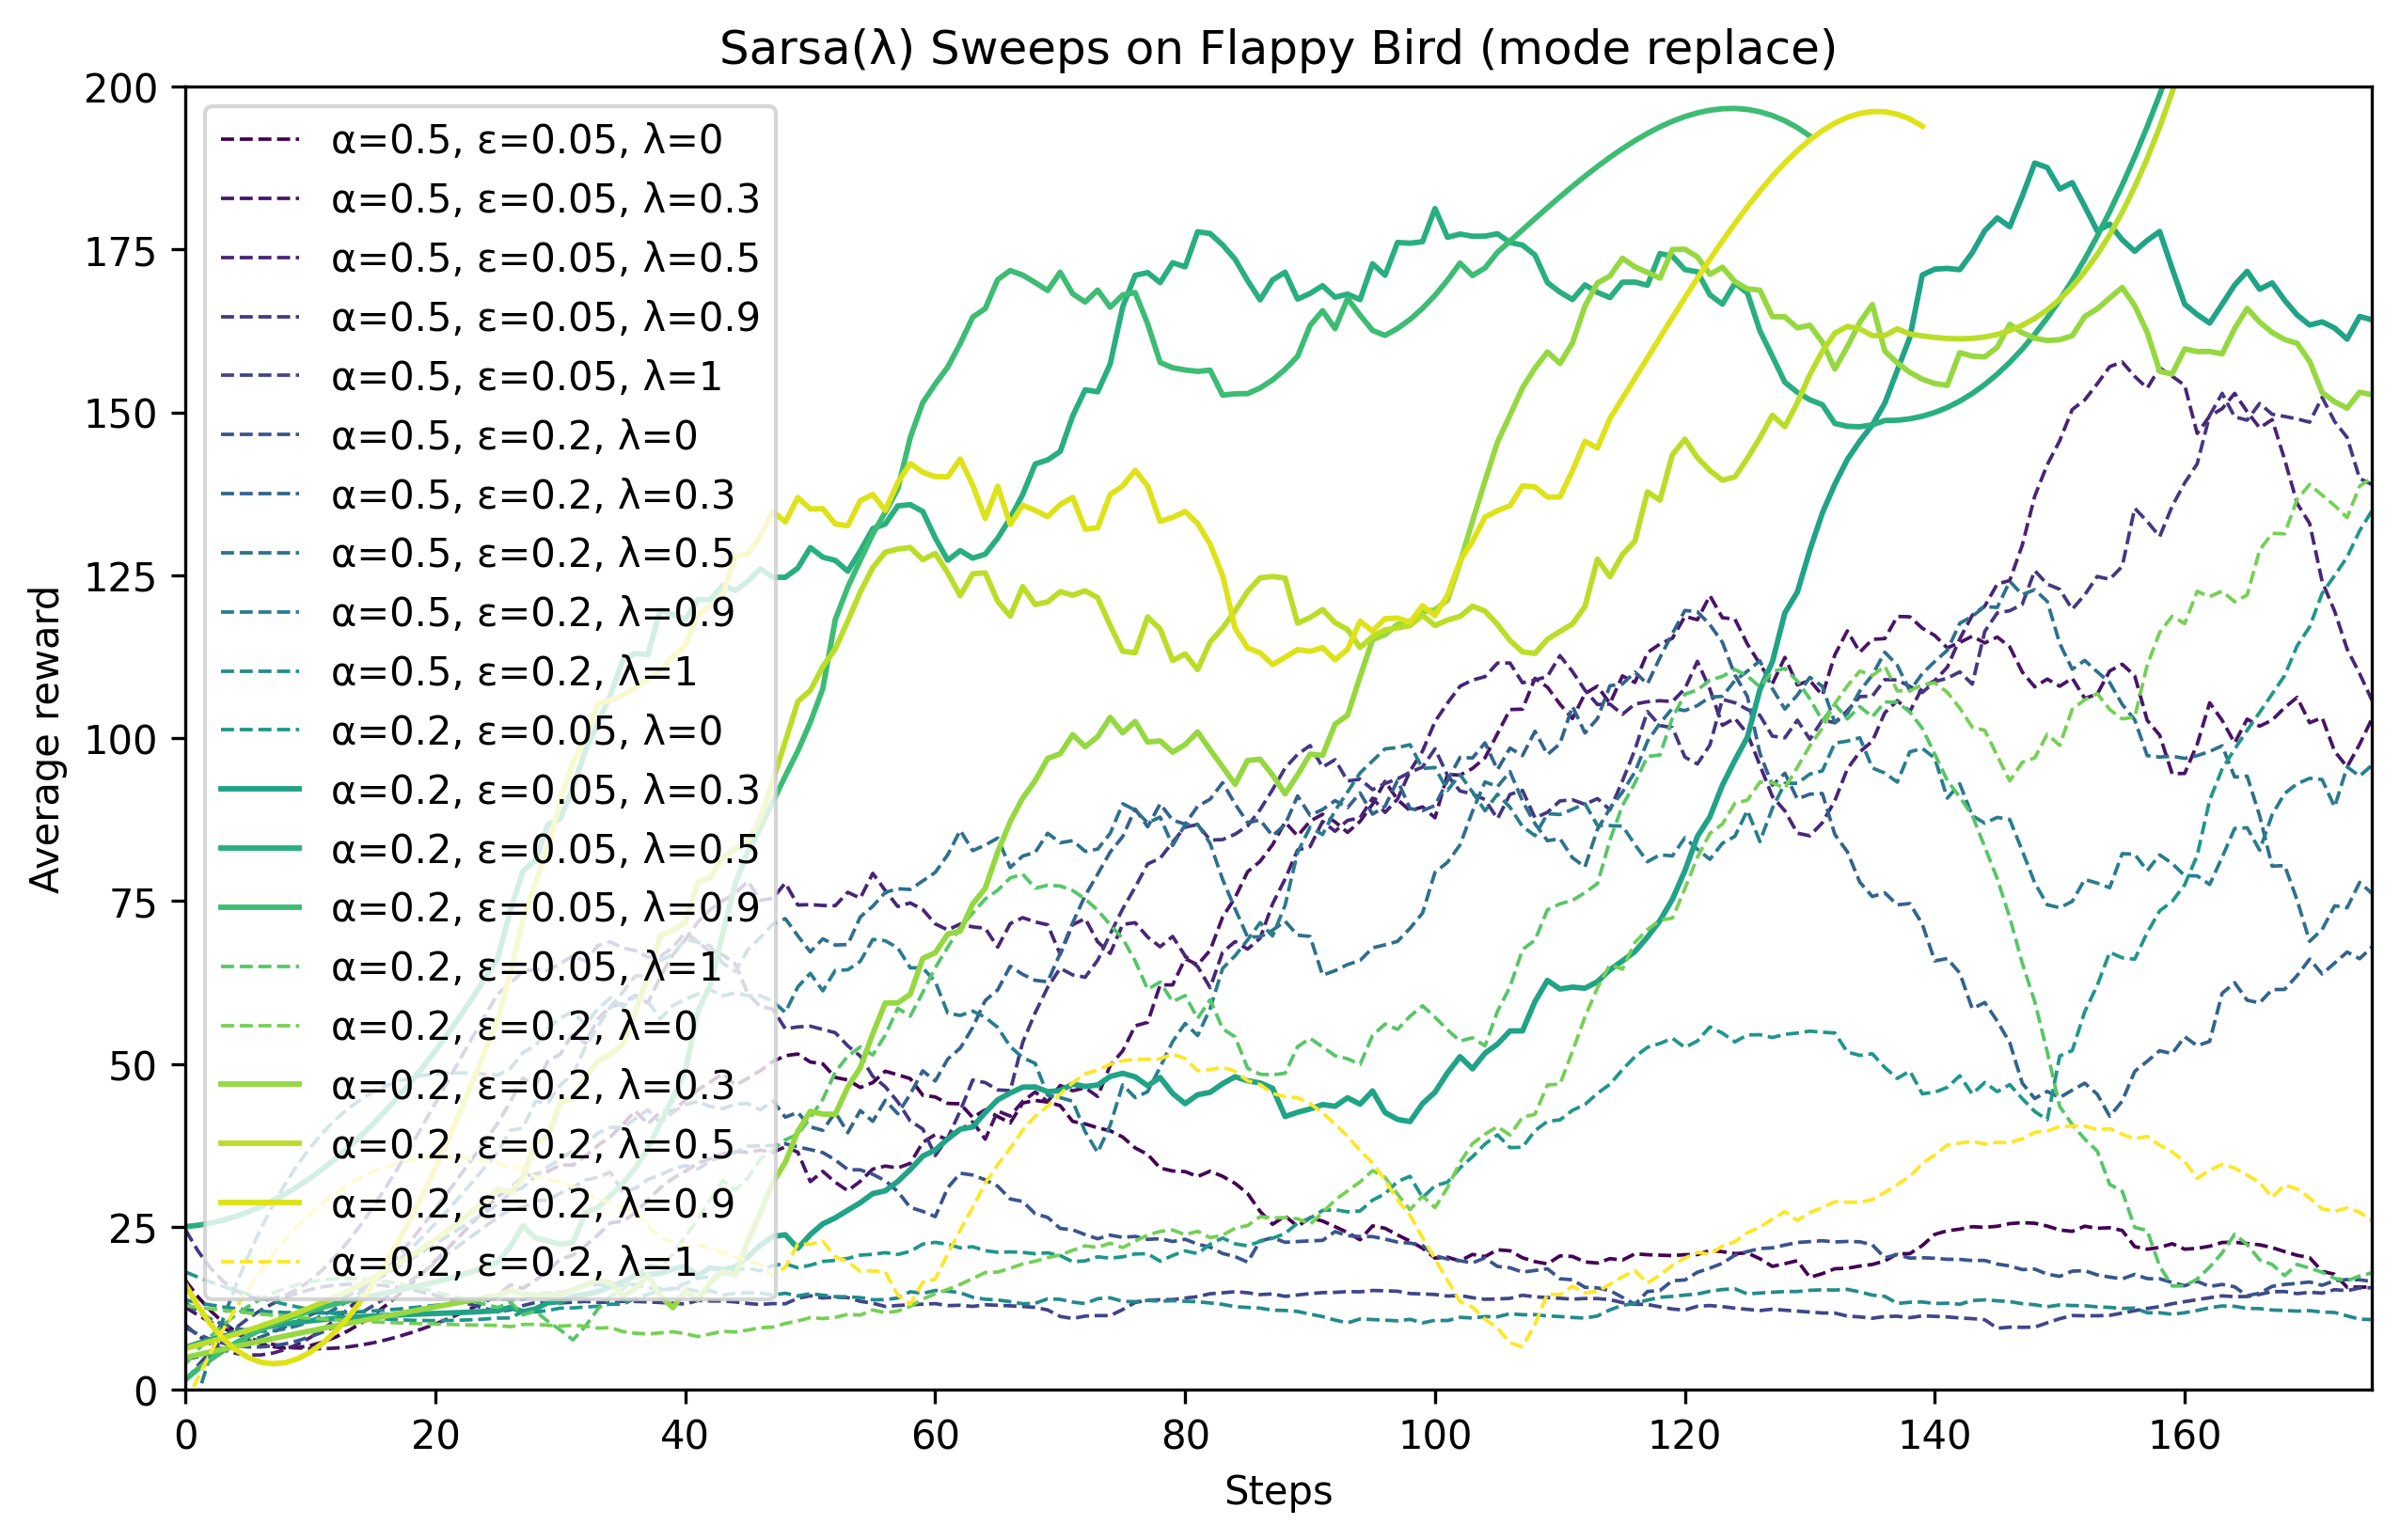

In [131]:
from scipy.signal import savgol_filter

# Viridis color map
palette = plt.get_cmap("viridis", len(rewards))
plt.figure(figsize=(10, 6), dpi=300)

# Plot the rewards
smooth_rewards = []
top_runs = {}
# # Import smoothing function
for i, (run_name, reward_list) in enumerate(rewards.items()):
    # plt.plot(reward_list, label=run_name, lw=0.8)
    smoothen = savgol_filter(reward_list, 51, 3)
    smooth_rewards.append(smoothen)
    _, a, e, g, l, m = run_name.split("_")
    run_name = f"α={a}, ε={e}, λ={l}"
    if smoothen[int(0.9*len(smoothen))] > 150:
        lw, ls = 1.4, "-"
        top_runs[run_name] = reward_list
    else: lw, ls = 0.9, "--"
    plt.plot(smoothen, label=run_name, lw=lw, color=palette(i), linestyle=ls)



plt.title("Sarsa(λ) Sweeps on Flappy Bird (mode replace)")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.legend()
plt.xlim(0, 175)
plt.ylim(0, 200)
plt.show()

(0.0, 200.0)

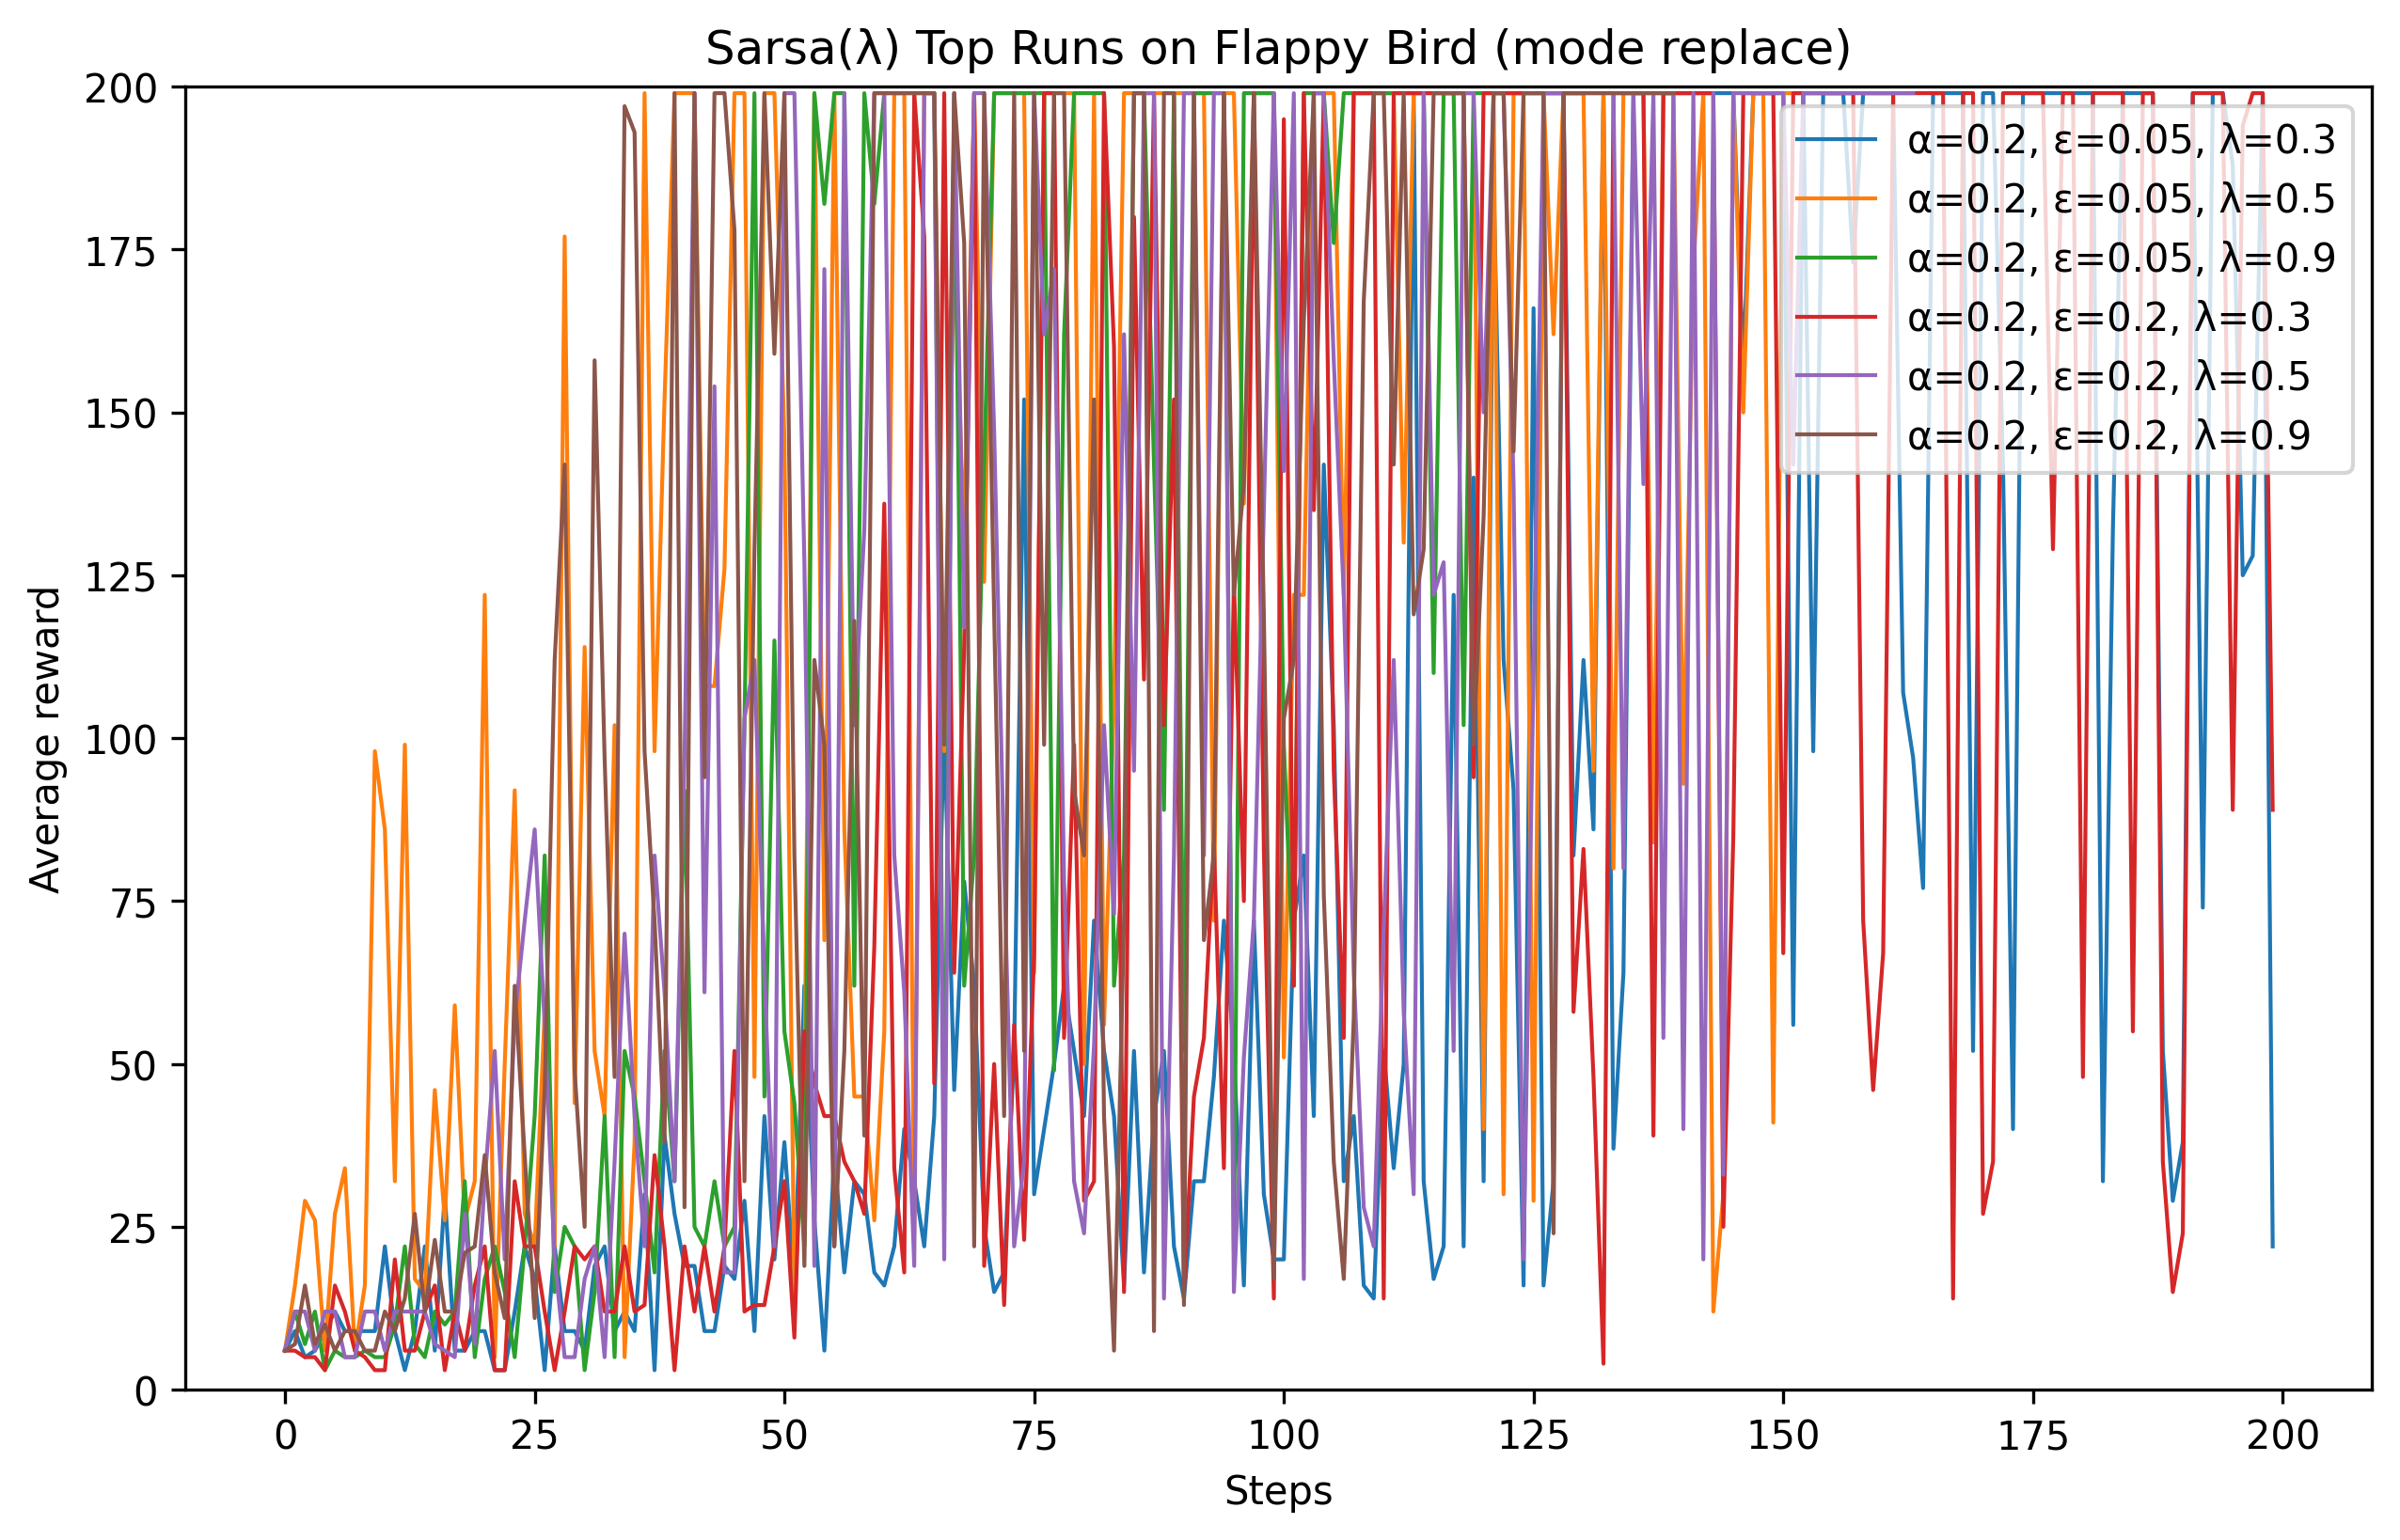

In [132]:
plt.figure(figsize=(10, 6), dpi=300)
for run_name, reward_list in top_runs.items():
    plt.plot(reward_list, label=run_name, lw=1.0)

plt.title("Sarsa(λ) Top Runs on Flappy Bird (mode replace)")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.legend()
plt.ylim(0, 200)

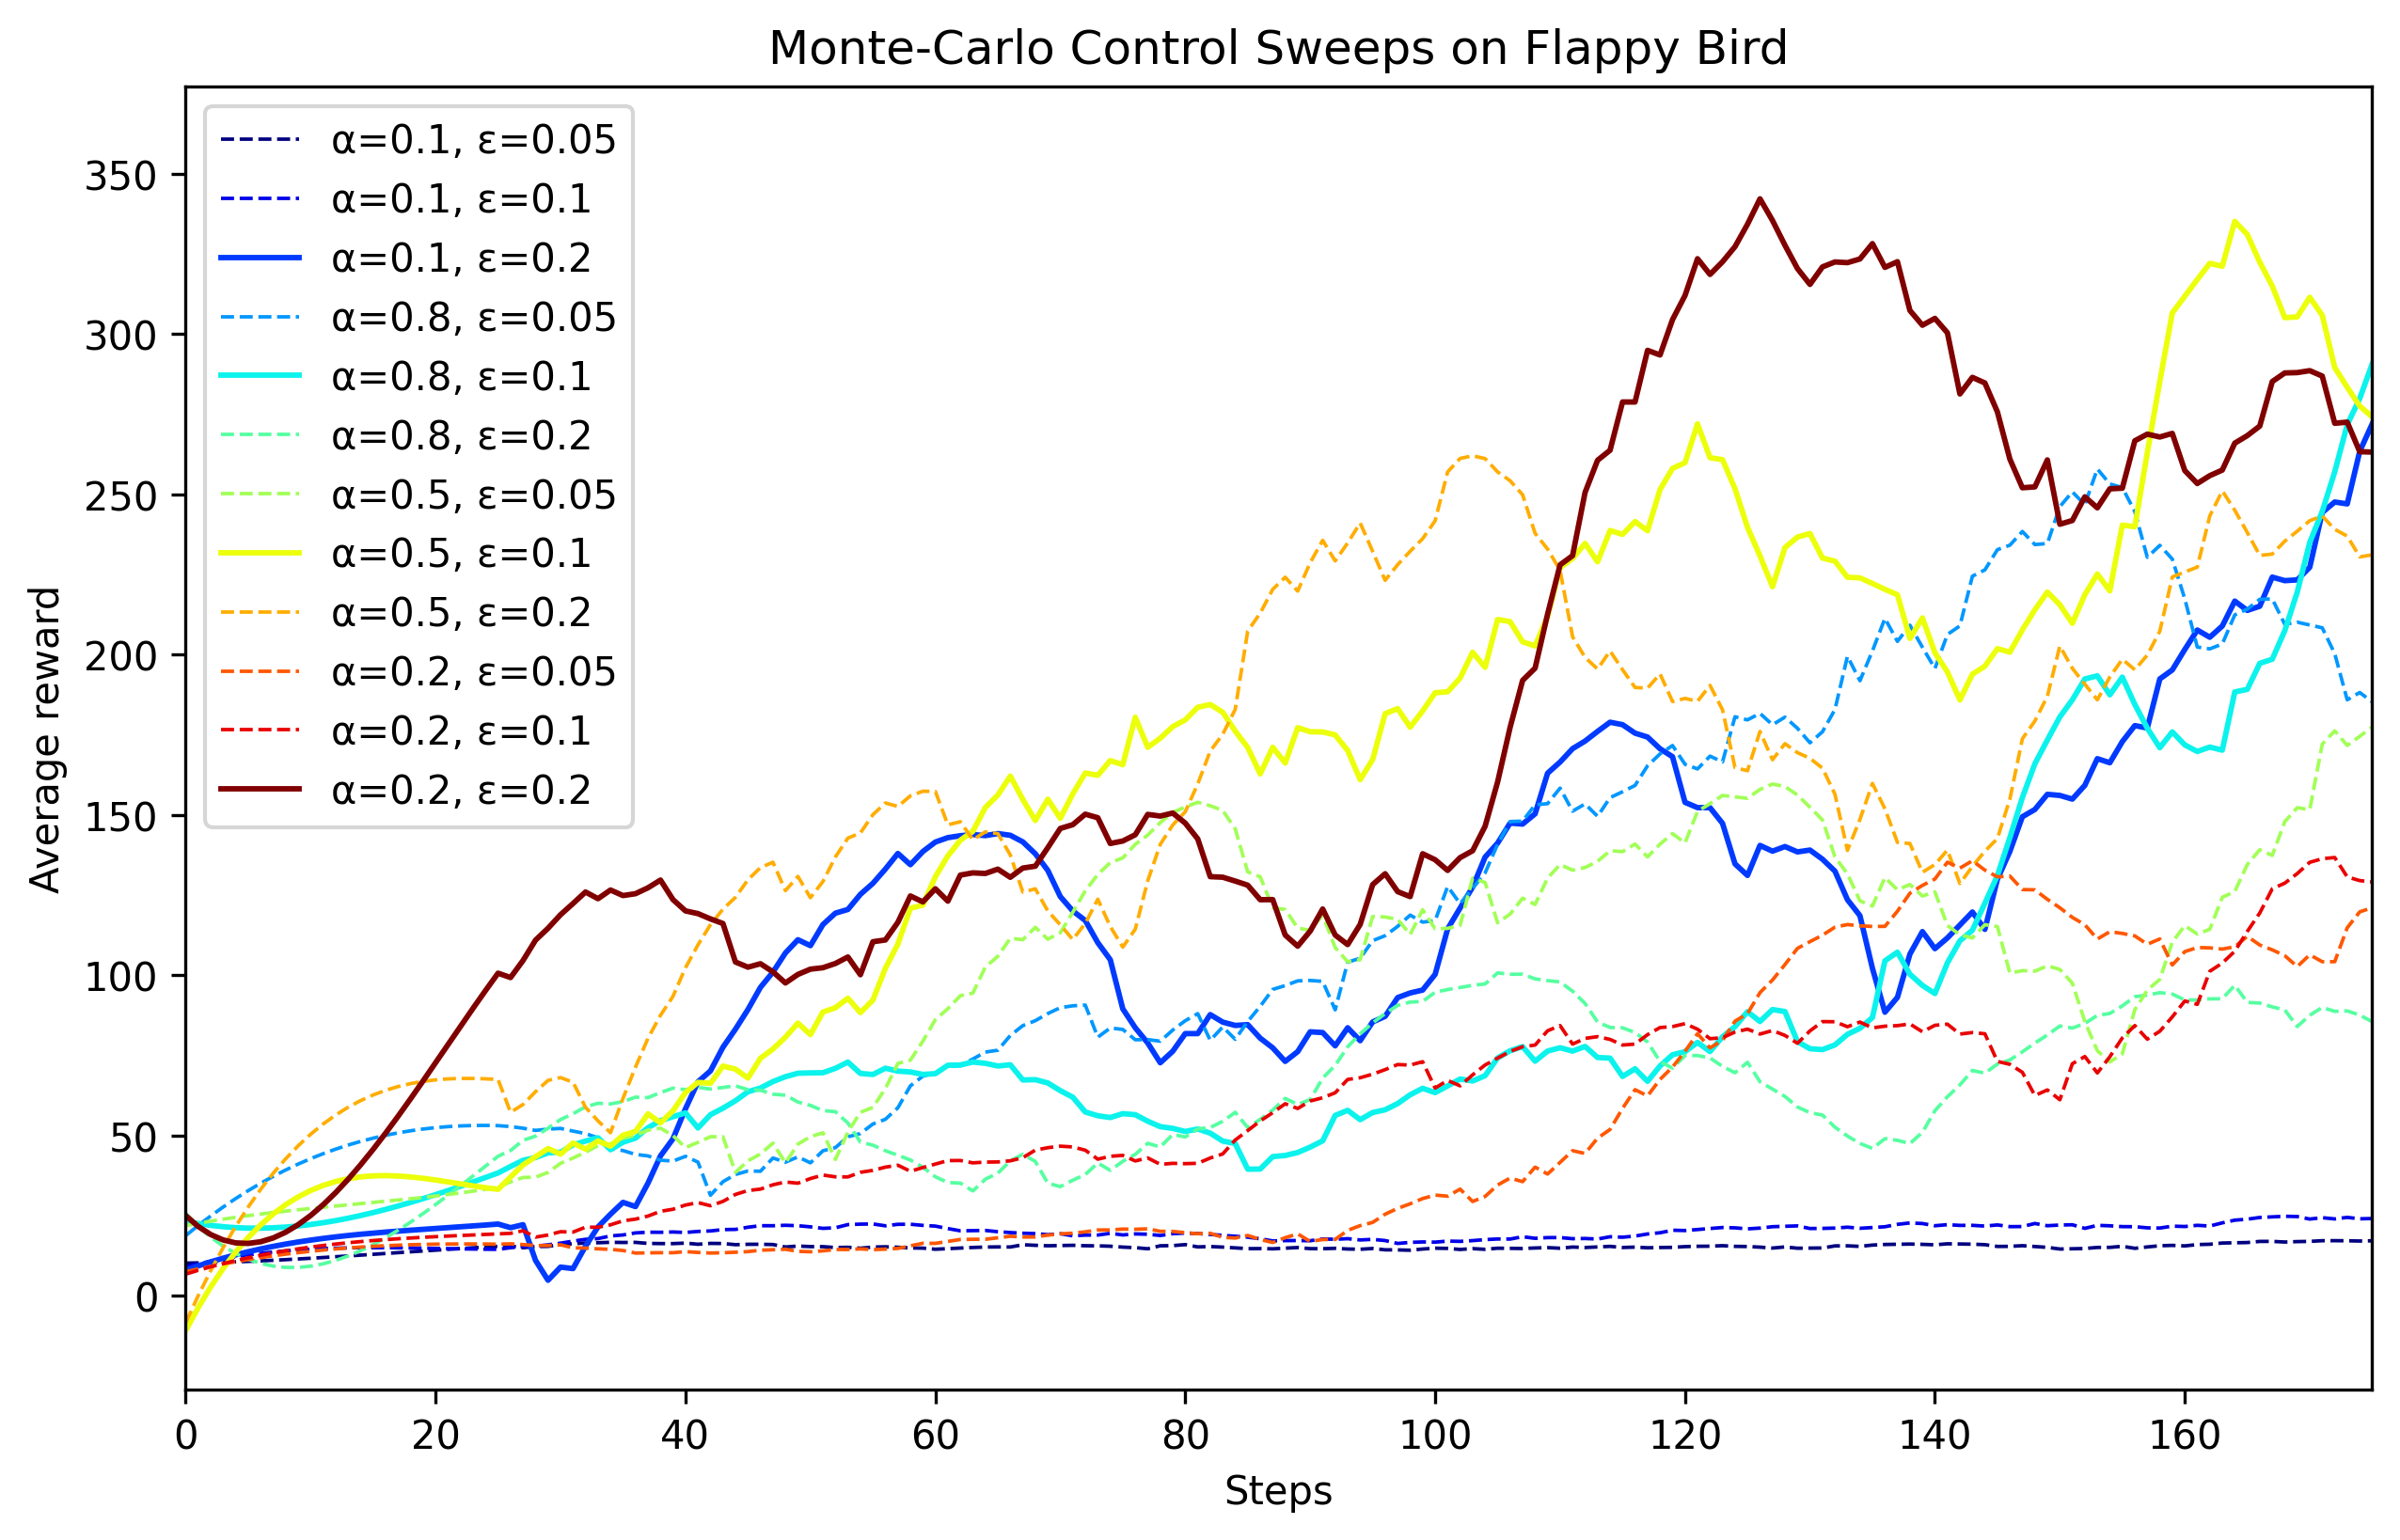

In [133]:
from scipy.signal import savgol_filter

# Viridis color map
palette = plt.get_cmap("jet", len(rewards_mc))
plt.figure(figsize=(10, 6), dpi=300)

# Plot the rewards
smooth_rewards = []
top_runs_mc = {}
# # Import smoothing function
for i, (run_name, reward_list) in enumerate(rewards_mc.items()):
    # plt.plot(reward_list, label=run_name, lw=0.8)
    smoothen = savgol_filter(reward_list, 51, 3)
    smooth_rewards.append(smoothen)
    _, a, e, d, m, g = run_name.split("_")
    run_name = f"α={a}, ε={e}"
    if smoothen[int(0.9*len(smoothen))] > 250:
        lw, ls = 1.4, "-"
        top_runs_mc[run_name] = reward_list
    else: lw, ls = 0.9, "--"
    plt.plot(smoothen, label=run_name, lw=lw, color=palette(i), linestyle=ls)

plt.title("Monte-Carlo Control Sweeps on Flappy Bird")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.legend()
plt.xlim(0, 175)
# plt.ylim(0, 200)
plt.show()

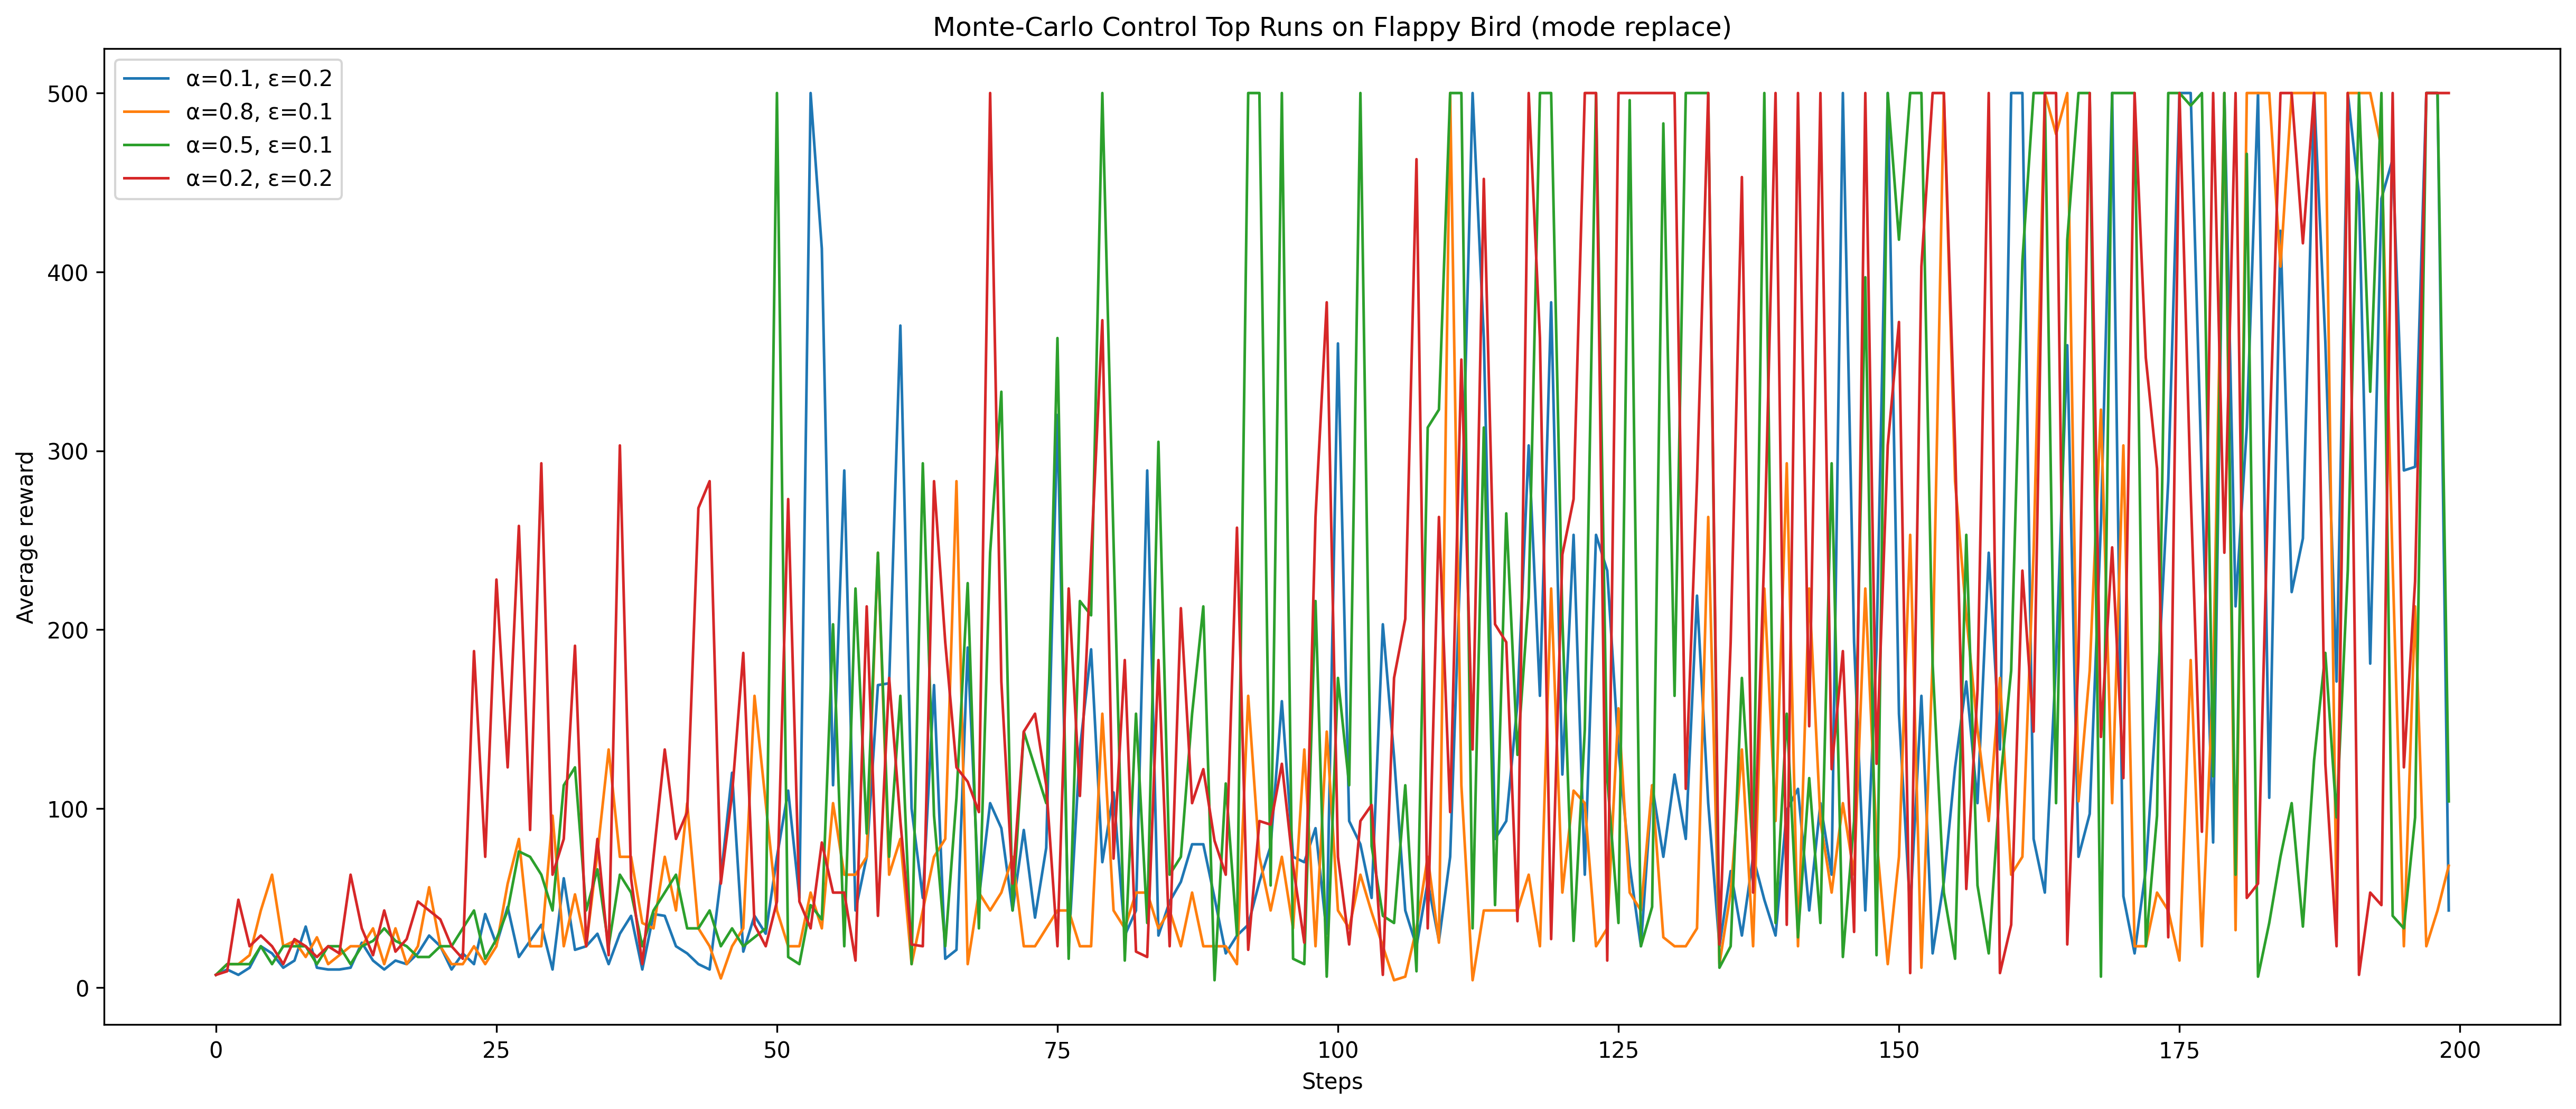

In [134]:
plt.figure(figsize=(20, 8), dpi=300)
for run_name, reward_list in top_runs_mc.items():
    plt.plot(reward_list, label=run_name, lw=1.2)

plt.title("Monte-Carlo Control Top Runs on Flappy Bird (mode replace)")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.legend()
# plt.ylim(0, 250)

### Pretrain agent on different configurations

In [135]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
obs, info = env.reset()

reward_list, agent = run_mc(
    alpha=0.5,
    epsilon=0.05,
    epsilon_decay=0.999,
    epsilon_min=0.01,
    gamma=0.99,
    num_episodes=5000,
    max_steps=400,
    env=env,
)

Episode 5000 - Reward: 293: 100%|██████████| 5000/5000 [01:22<00:00, 60.57it/s] 


Text(0, 0.5, 'Average reward')

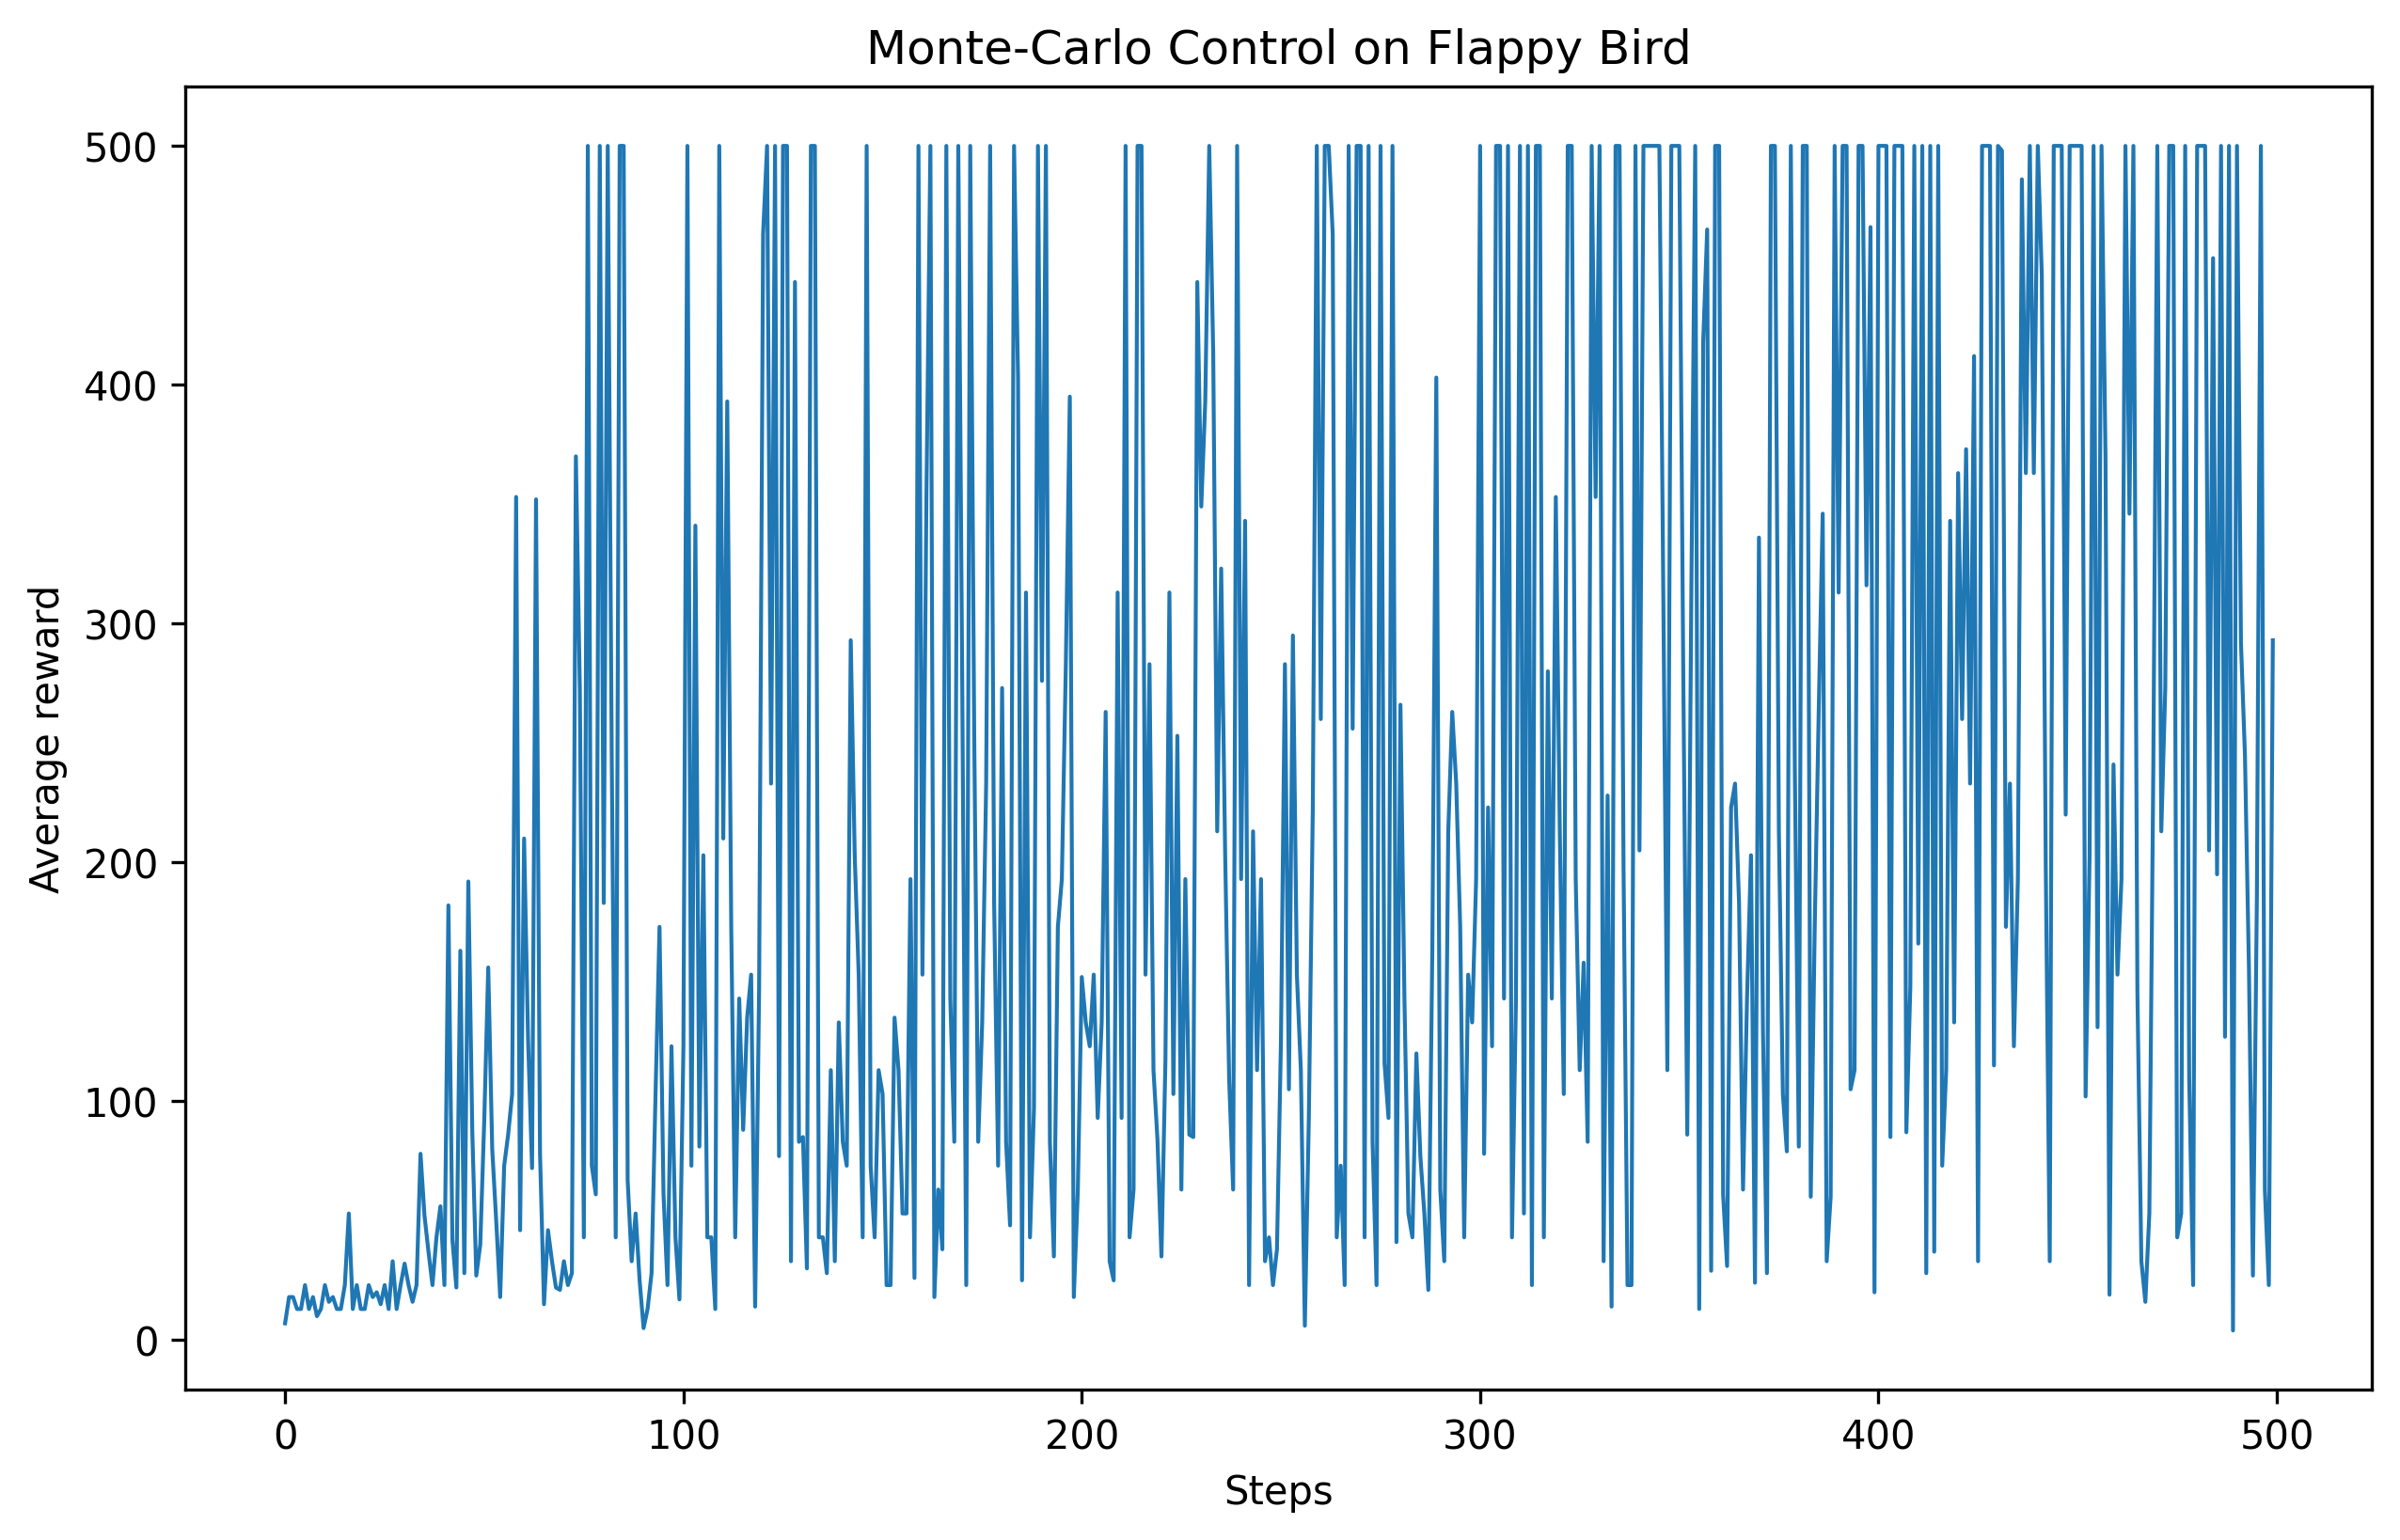

In [137]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(reward_list, label="MC(α=0.5, ε=0.05)", lw=1.0)
plt.title("Monte-Carlo Control on Flappy Bird")
plt.xlabel("Steps")
plt.ylabel("Average reward")

In [136]:
agent.save_policy("results/mc_policy.npy")

In [138]:
def evaluate(agent, env, num_episodes=1000):
    rewards = []
    for episode in trange(num_episodes):
        obs, _ = env.reset()
        agent.epsilon = 0
        agent.set_seed(episode)
        length = agent.agent_step(env)
        rewards.append(length)
    return rewards

In [139]:
simple_env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
square_env = gym.make("TextFlappyBird-v0", height=30, width=30, pipe_gap=4)
small_env = gym.make("TextFlappyBird-v0", height=10, width=10, pipe_gap=4)
big_env = gym.make("TextFlappyBird-v0", height=50, width=50, pipe_gap=4)

print("Evaluating MC on simple environment")
simple_env.reset()
simple_rewards = evaluate(agent, simple_env, num_episodes=500)

print("Evaluating MC on square environment")
square_env.reset()
square_rewards = evaluate(agent, square_env, num_episodes=500)

print("Evaluating MC on small environment")
small_env.reset()
small_rewards = evaluate(agent, small_env, num_episodes=500)

print("Evaluating MC on big environment")
big_env.reset()
big_rewards = evaluate(agent, big_env, num_episodes=500)

Evaluating MC on simple environment


100%|██████████| 500/500 [00:18<00:00, 27.42it/s]


Evaluating MC on square environment


100%|██████████| 500/500 [00:01<00:00, 432.61it/s]


Evaluating MC on small environment


100%|██████████| 500/500 [00:01<00:00, 274.91it/s]


Evaluating MC on big environment


100%|██████████| 500/500 [00:00<00:00, 507.57it/s]


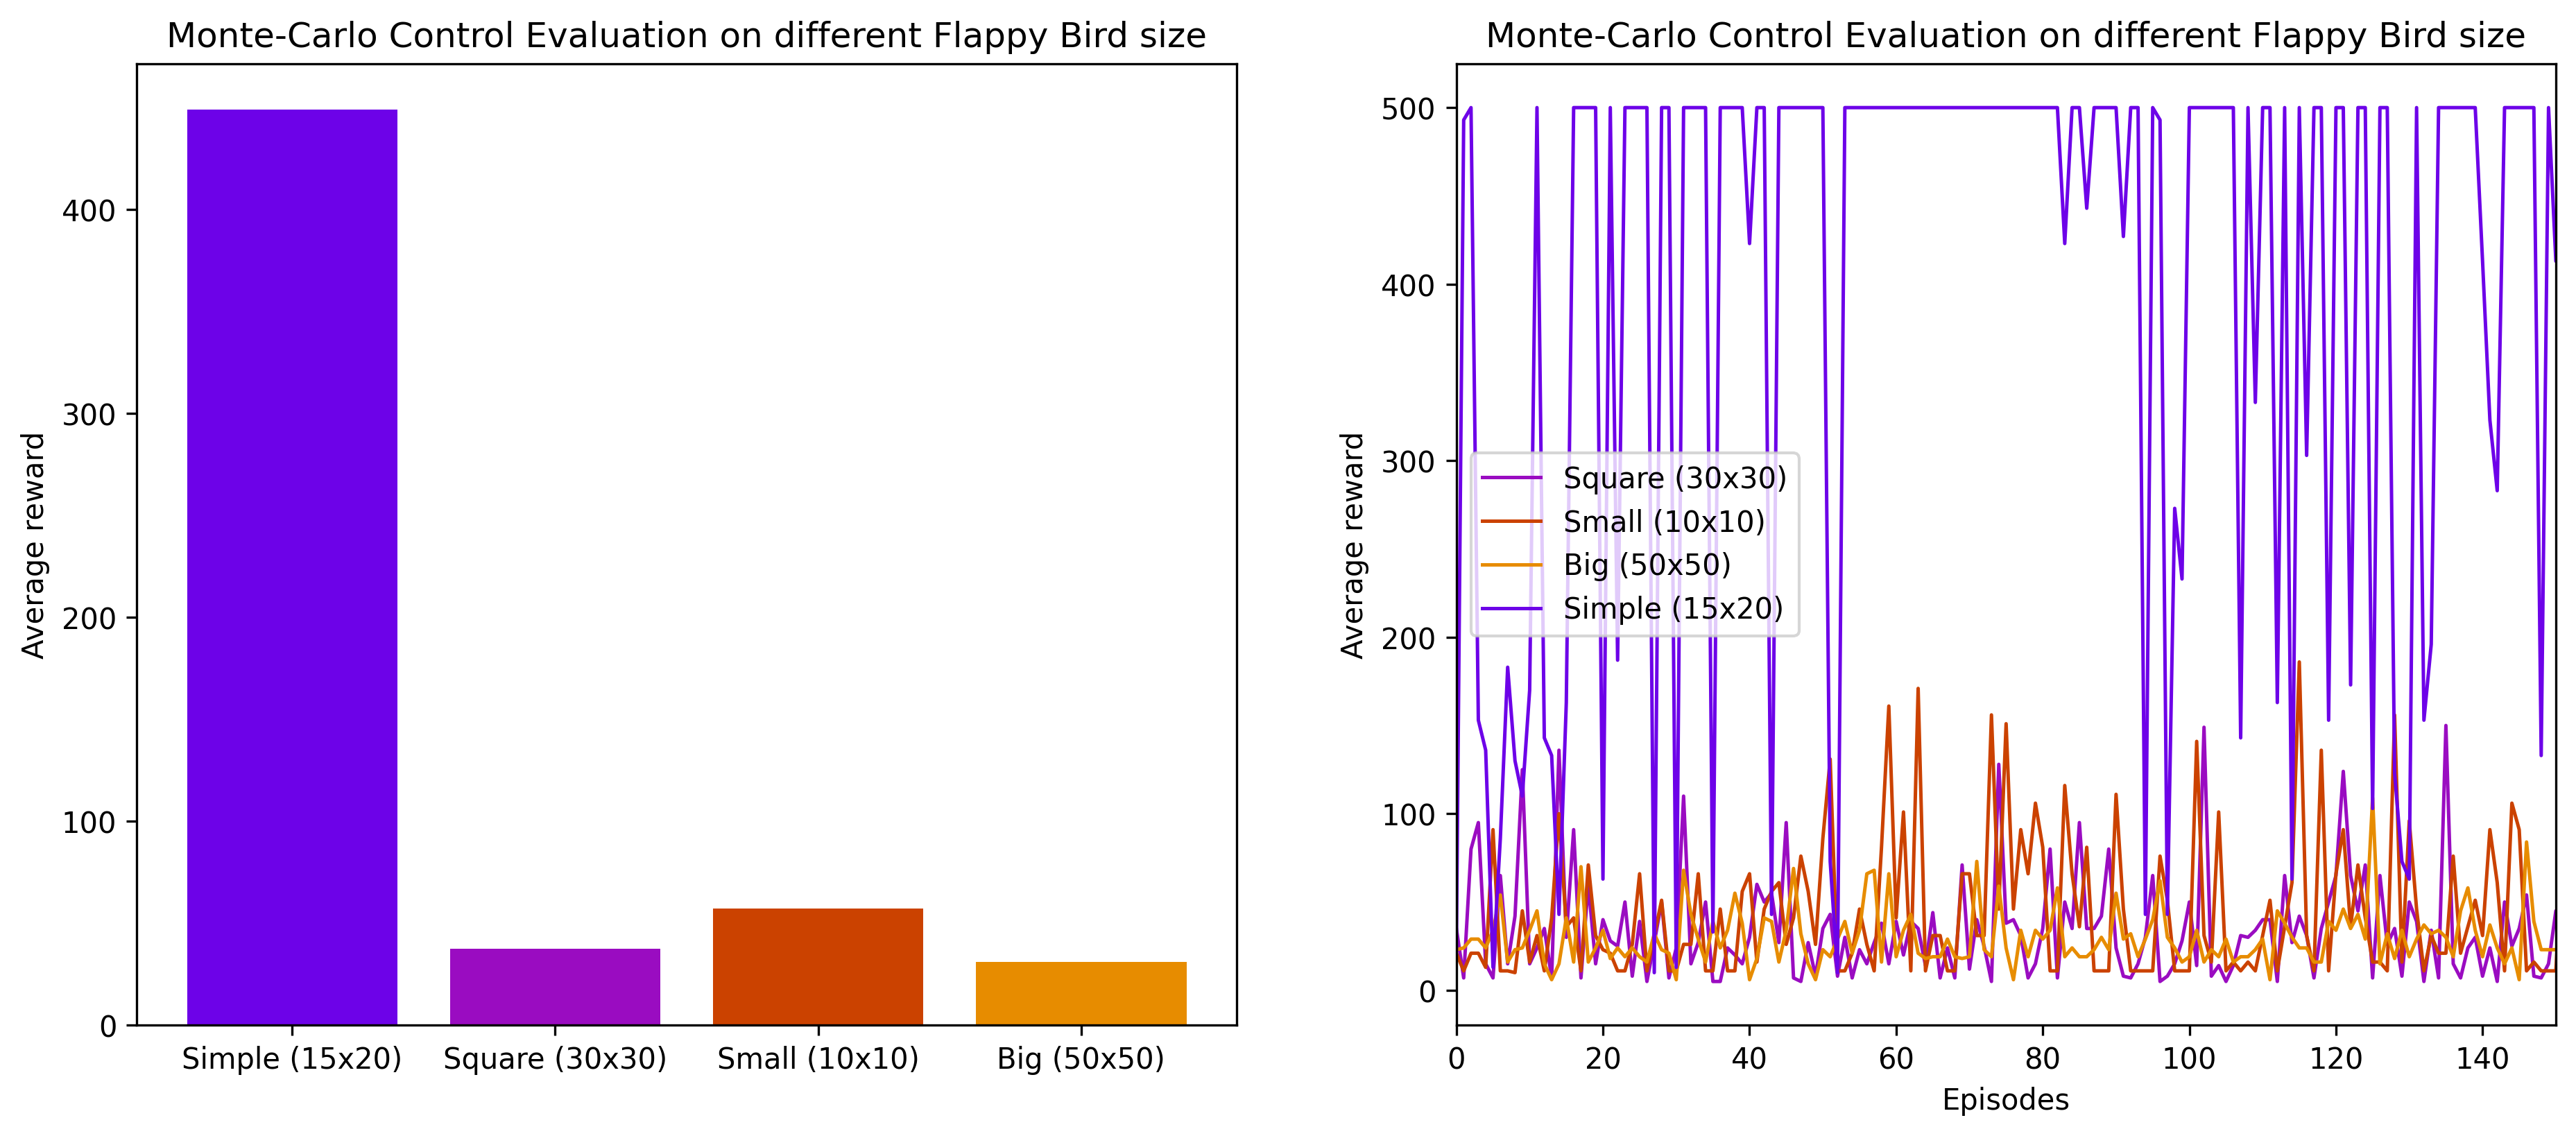

In [140]:
plt.figure(figsize=(15, 6), dpi=300)

# gnuplot colormap
palette = plt.get_cmap("gnuplot", 12)

plt.subplot(1, 2, 1)
plt.bar(
    ["Simple (15x20)", "Square (30x30)", "Small (10x10)", "Big (50x50)"],
    [np.mean(simple_rewards), np.mean(square_rewards), np.mean(small_rewards), np.mean(big_rewards)],
    color=[palette(2), palette(4), palette(7), palette(9)],
)
plt.title("Monte-Carlo Control Evaluation on different Flappy Bird size")
plt.ylabel("Average reward")

plt.subplot(1, 2, 2)
plt.plot(square_rewards, label="Square (30x30)", lw=1.2, color=palette(4))
plt.plot(small_rewards, label="Small (10x10)", lw=1.2, color=palette(7))
plt.plot(big_rewards, label="Big (50x50)", lw=1.2, color=palette(9))
plt.plot(simple_rewards, label="Simple (15x20)", lw=1.2, color=palette(2))
plt.title("Monte-Carlo Control Evaluation on different Flappy Bird size")
plt.xlabel("Episodes")
plt.ylabel("Average reward")
plt.xlim(0, 150)
plt.legend()

In [141]:
big_gap_env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=10)
medium_gap_env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=6)
small_gap_env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=2)
normal_gap_env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

print("Evaluating MC on big gap environment")
big_gap_env.reset()
big_gap_rewards = evaluate(agent, big_gap_env, num_episodes=500)

print("Evaluating MC on medium gap environment")
medium_gap_env.reset()
medium_gap_rewards = evaluate(agent, medium_gap_env, num_episodes=500)

print("Evaluating MC on small gap environment")
small_gap_env.reset()
small_gap_rewards = evaluate(agent, small_gap_env, num_episodes=500)

print("Evaluating MC on normal gap environment")
normal_gap_env.reset()
normal_gap_rewards = evaluate(agent, normal_gap_env, num_episodes=500)

Evaluating MC on big gap environment


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Evaluating MC on medium gap environment


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Evaluating MC on small gap environment


100%|██████████| 500/500 [00:07<00:00, 64.49it/s] 


Evaluating MC on normal gap environment


100%|██████████| 500/500 [00:18<00:00, 27.13it/s]


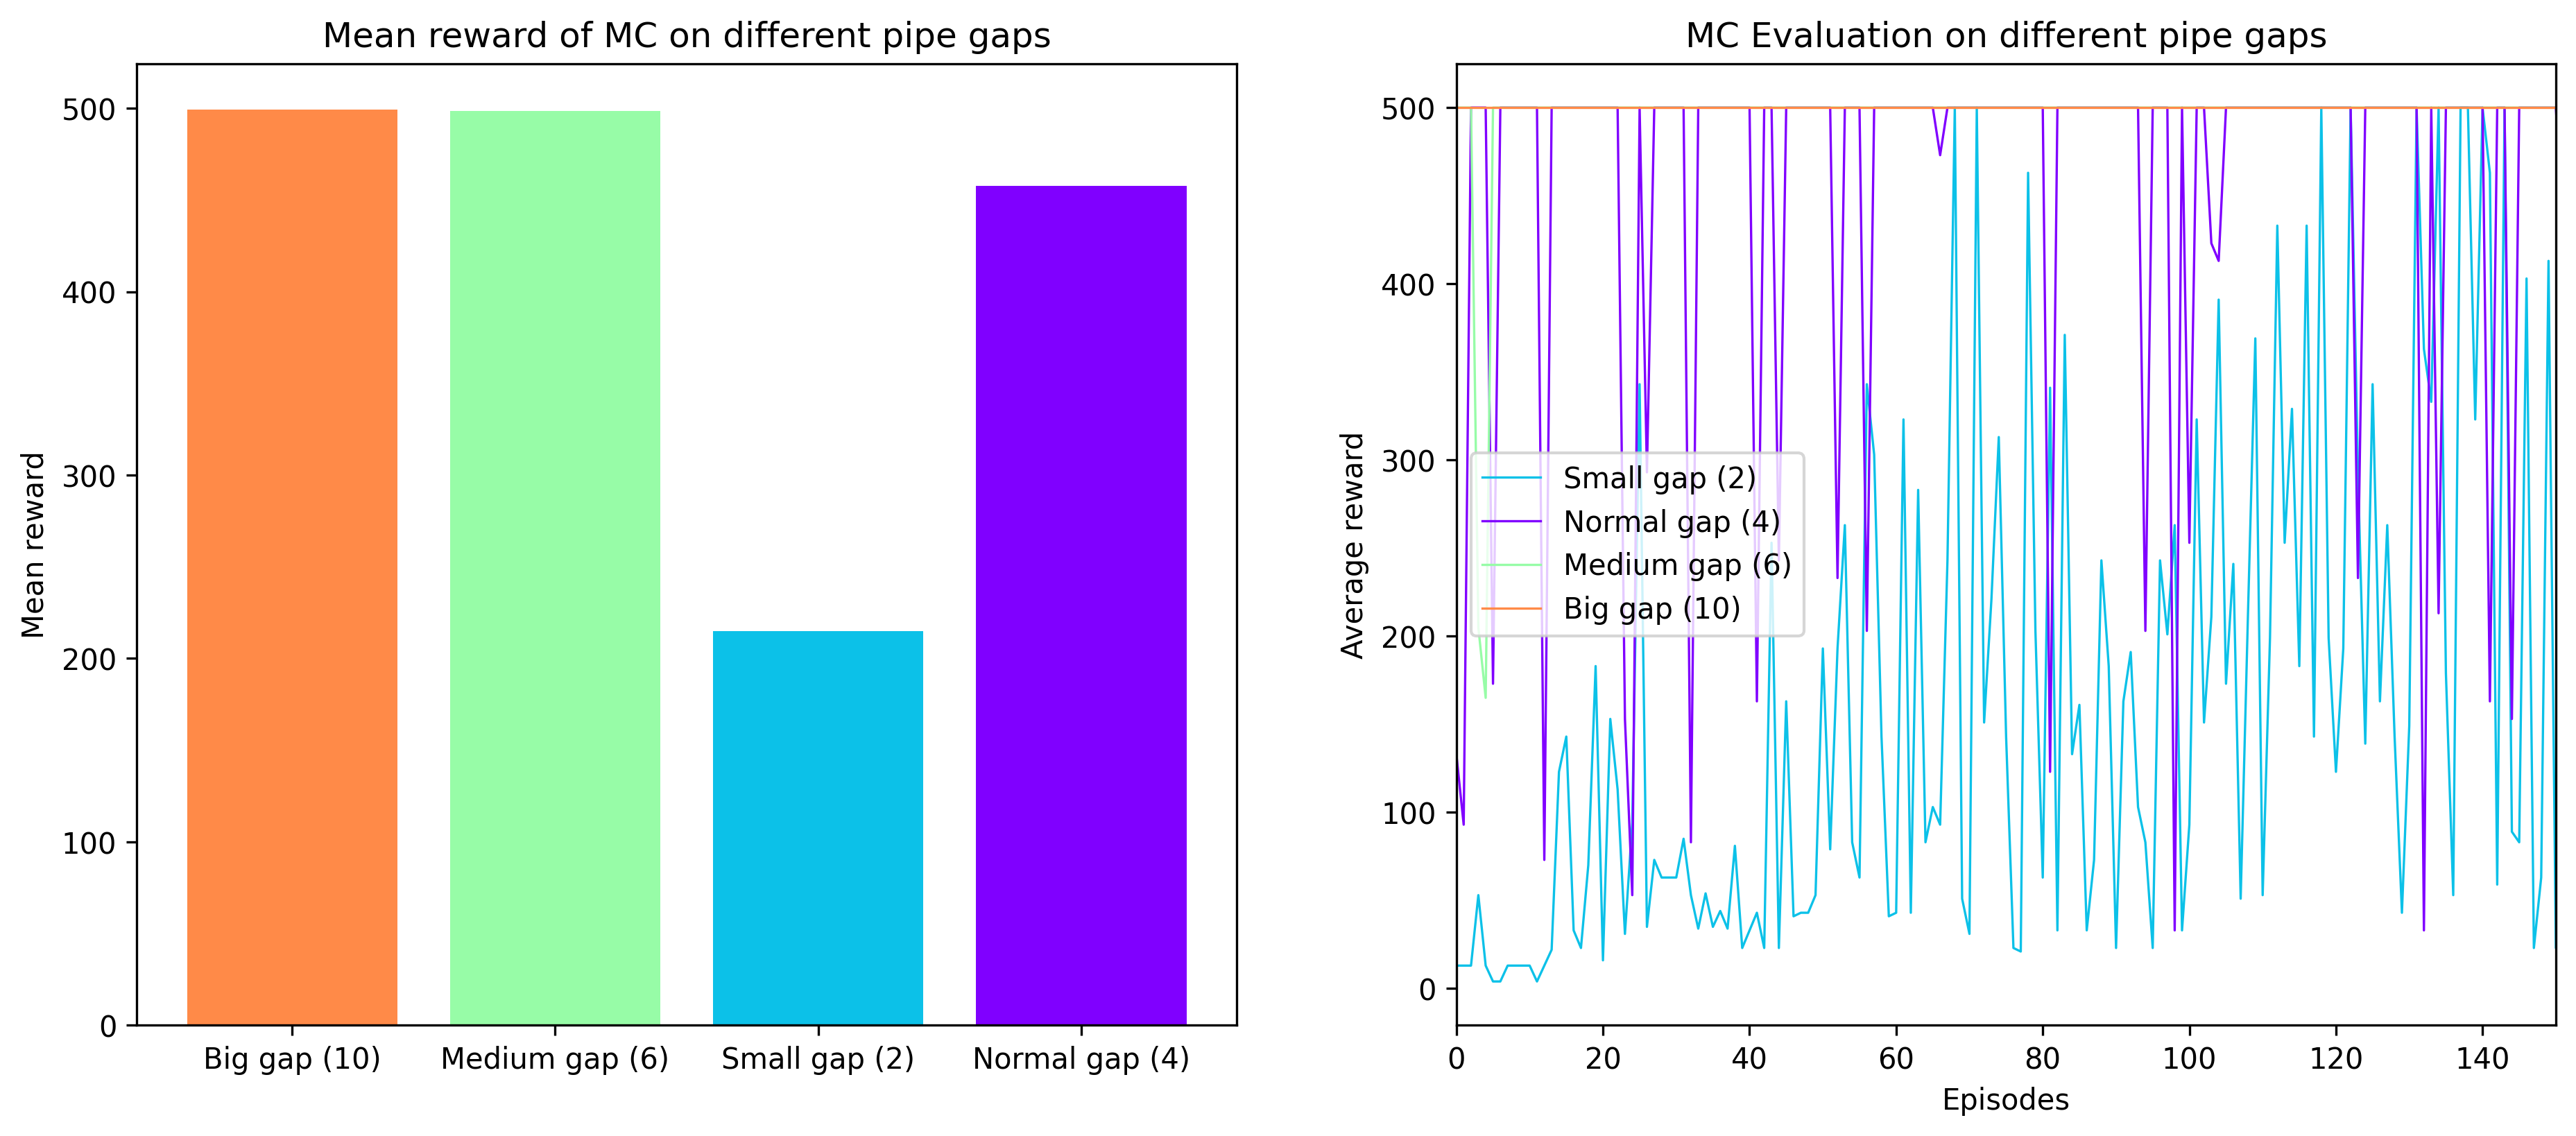

In [143]:
plt.figure(figsize=(15, 6), dpi=300)

palette = plt.get_cmap("rainbow", 12)

# Bar plot of the mean rewards
plt.subplot(1, 2, 1)
plt.bar(
    ["Big gap (10)", "Medium gap (6)", "Small gap (2)", "Normal gap (4)"],
    [np.mean(big_gap_rewards), np.mean(medium_gap_rewards), np.mean(small_gap_rewards), np.mean(normal_gap_rewards)],
    color=[palette(9), palette(6), palette(3), palette(0)],
)
plt.title("Mean reward of MC on different pipe gaps")
plt.ylabel("Mean reward")

plt.subplot(1, 2, 2)
plt.plot(small_gap_rewards, label="Small gap (2)", lw=0.8, color=palette(3))
plt.plot(normal_gap_rewards, label="Normal gap (4)", lw=0.8, color=palette(0))
plt.plot(medium_gap_rewards, label="Medium gap (6)", lw=0.8, color=palette(6))
plt.plot(big_gap_rewards, label="Big gap (10)", lw=0.8, color=palette(9))
plt.title("MC Evaluation on different pipe gaps")
plt.xlabel("Episodes")
plt.ylabel("Average reward")
plt.xlim(0, 150)
plt.legend()

### State-Value function plots

In [191]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
obs, info = env.reset()

reward_list, agent_mc = run_mc(
    alpha=0.5,
    epsilon=0.05,
    epsilon_decay=0.999,
    epsilon_min=0.01,
    gamma=0.99,
    num_episodes=5000,
    max_steps=400,
    env=env,
)

Episode 5000 - Reward: 500: 100%|██████████| 5000/5000 [02:03<00:00, 40.48it/s]


In [178]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
obs, info = env.reset()

reward_list_sarsa, agent_sarsa = run_sarsa(
    alpha=0.2,
    epsilon=0.05,
    lambda_=0.5,
    gamma=0.99,
    mode="replace",
    num_episodes=5000,
    max_steps=400,
    env=env,
)

Episode 2761 - Reward: 399:  55%|█████▌    | 2761/5000 [03:45<03:02, 12.25it/s]


In [196]:
ks = agent_mc.Q.keys()
min0, max0 = min([k[0] for k in ks]), max([k[0] for k in ks])
min1, max1 = min([k[1] for k in ks]), max([k[1] for k in ks])

print(min0, max0)
print(min1, max1)

0 13
-12 12


In [197]:
def get_q(agent):
    # Create an Q function from agent.Q where each value is the index of the max action (0 idle, 1 flap)
    Qfunc = {}
    for state, actions in agent.Q.items():
        Qfunc[state] = np.argmax(actions)
    # Create an image from Qfunc of shape 15x20 that will be plotted
    image = np.zeros((15, 30))
    for state, action in Qfunc.items():
        x, y = state
        image[x, y+15] = action

    return image

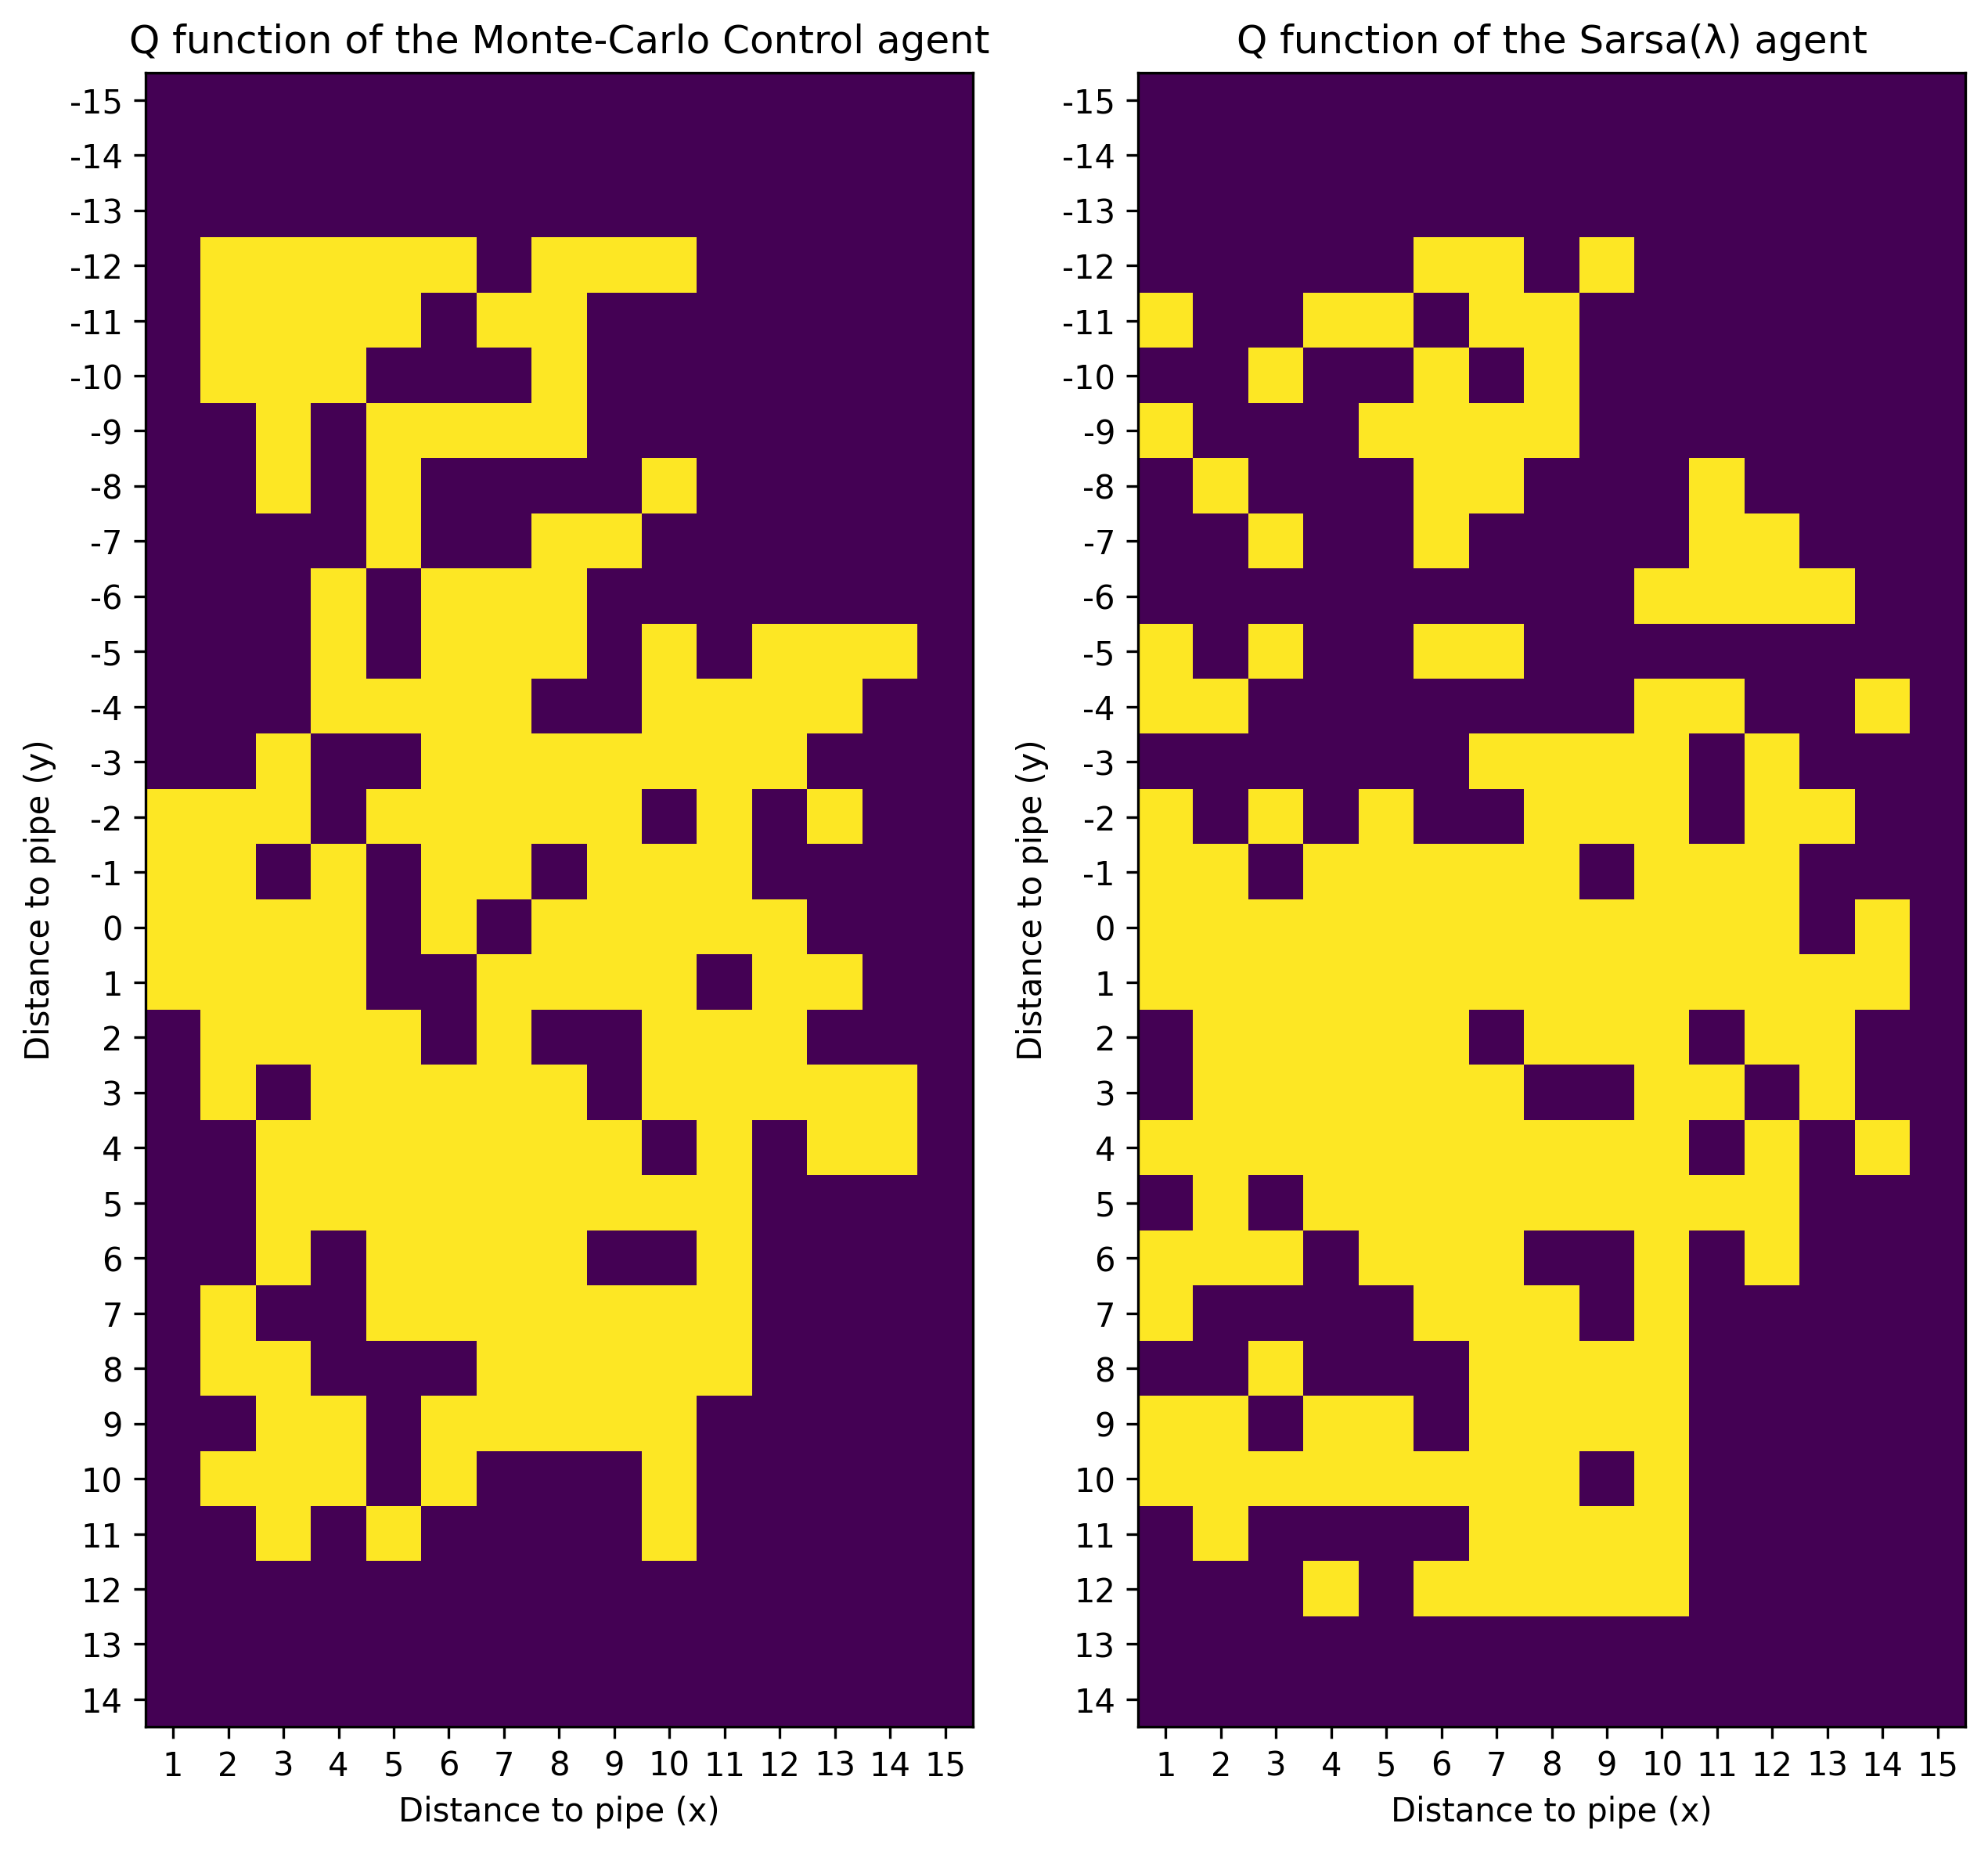

In [212]:
# Plot a grid of the Q function
plt.figure(figsize=(10, 15), dpi=300)

plt.subplot(1, 2, 1)
plt.imshow(get_q(agent_mc).T, cmap="viridis")
# plt.colorbar()
plt.xlabel("Distance to pipe (x)")
plt.ylabel("Distance to pipe (y)")
plt.xticks(np.arange(0, 15, 1), np.arange(1, 16, 1))
plt.yticks(np.arange(0, 30, 1), np.arange(-15, 15, 1))
plt.title("Q function of the Monte-Carlo Control agent")

plt.subplot(1, 2, 2)
plt.imshow(get_q(agent_sarsa).T, cmap="viridis")
# plt.colorbar()
plt.xlabel("Distance to pipe (x)")
plt.ylabel("Distance to pipe (y)")
plt.xticks(np.arange(0, 15, 1), np.arange(1, 16, 1))
plt.yticks(np.arange(0, 30, 1), np.arange(-15, 15, 1))
plt.title("Q function of the Sarsa(λ) agent")
plt.show()

### Test on Real Flappy Bird environment

In [269]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
obs, info = env.reset()

reward_list, agent_mc = run_mc(
    alpha=0.5,
    epsilon=0.05,
    epsilon_decay=0.999,
    epsilon_min=0.01,
    gamma=0.99,
    num_episodes=5000,
    max_steps=500,
    env=env,
)

Episode 5000 - Reward: 170: 100%|██████████| 5000/5000 [01:02<00:00, 80.18it/s] 


In [271]:
import random

def evaluate_flappy(agent, env, num_episodes=1000, v1=False):
    rewards = []
    for episode in trange(num_episodes):
        random.seed(episode)
        np.random.seed(episode)
        obs = env.reset()
        agent.epsilon = 0
        agent.set_seed(episode)
        length = agent.agent_step(env, v1=v1)
        rewards.append(length)
    return rewards

In [272]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
rewards_text_flappy = evaluate(agent_mc, env, num_episodes=1000)

100%|██████████| 1000/1000 [00:37<00:00, 26.67it/s]


In [325]:
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")

reward_list_flappy, agent_mc_flappy = run_mc(
    alpha=0.19,
    epsilon=0.5,
    epsilon_decay=0.999,
    epsilon_min=0.01,
    gamma=0.99,
    num_episodes=2000,
    max_steps=1000,
    env=env,
)
rewards_flappy = evaluate_flappy(agent_mc, env, num_episodes=1000, v1=True)

Episode 13 - Reward: 101:   1%|          | 13/2000 [00:00<00:17, 111.11it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'Average reward')

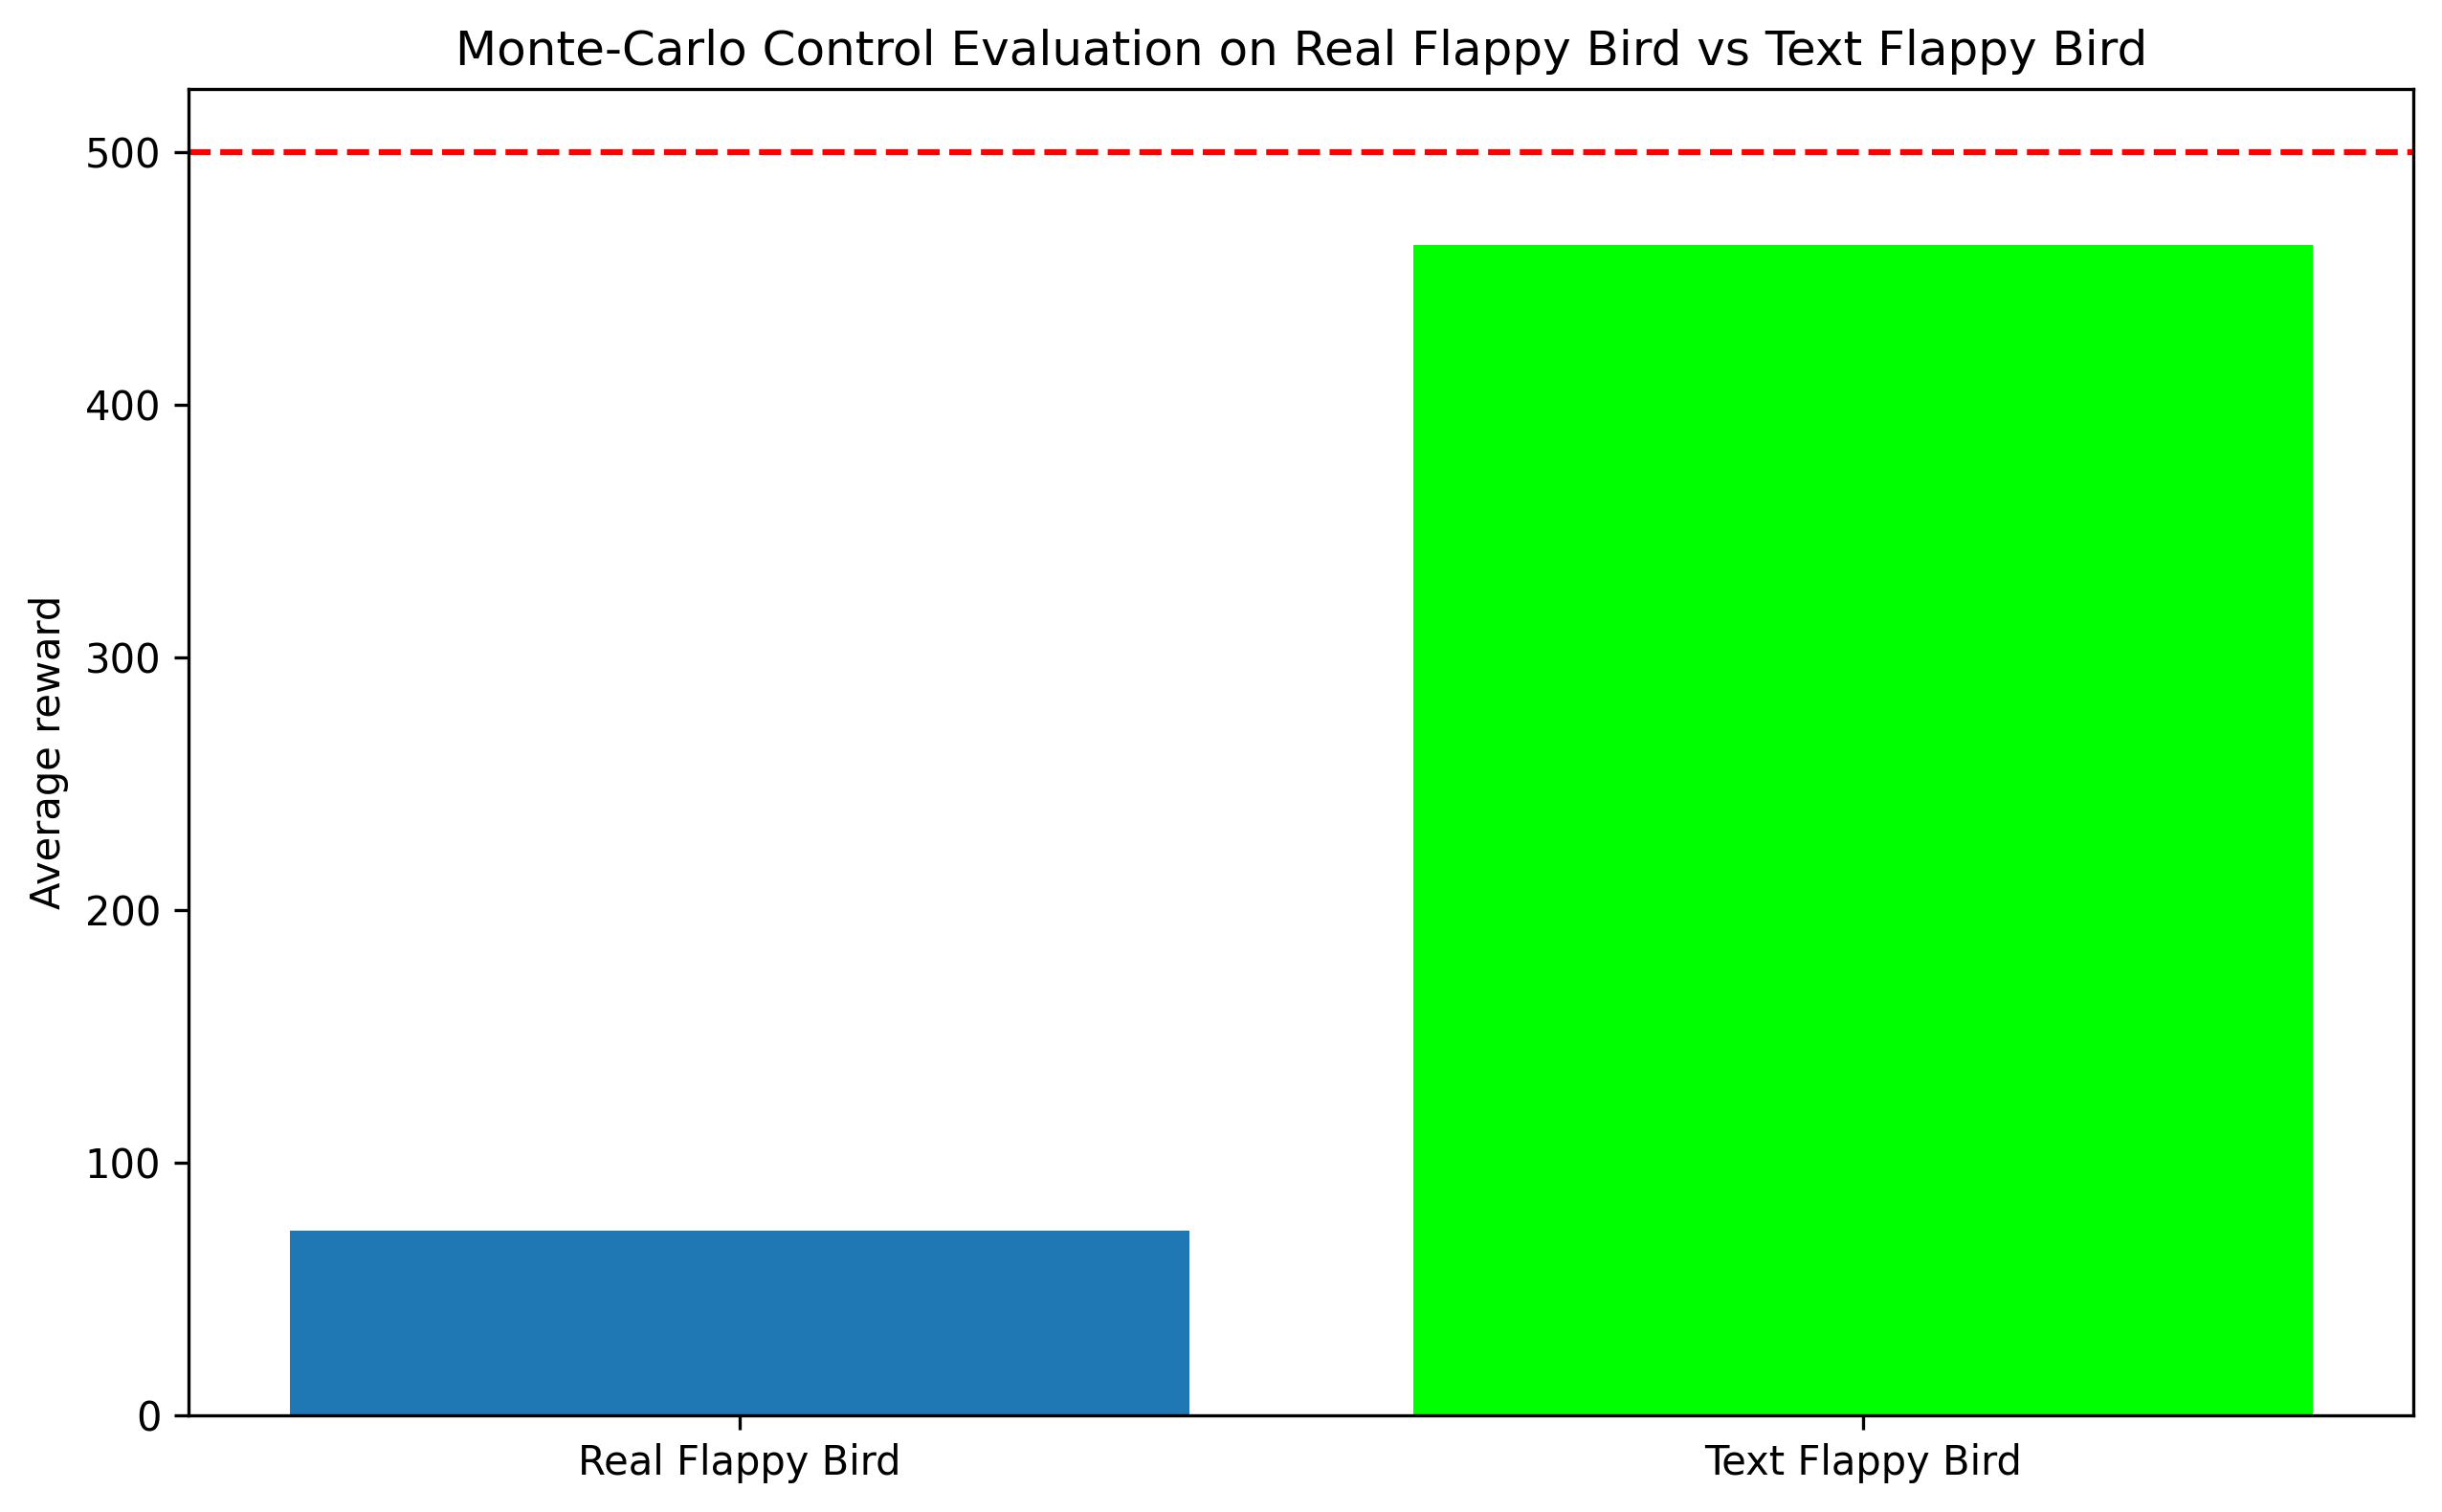

In [318]:
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(["Real Flappy Bird", "Text Flappy Bird"], [np.mean(rewards_flappy), np.mean(rewards_text_flappy)], color=["#1f77b4", "lime"])
plt.title("Monte-Carlo Control Evaluation on Real Flappy Bird vs Text Flappy Bird")
plt.axhline(500, color="red", linestyle="--")
plt.ylabel("Average reward")